--
title: Exploring modeling failure
mathjax: True
--

> In [my last post], I gave an example of a multilevel model using a binomial generalized linear model (GLM). The varying intercept model helped illustrate partial pooling, shrinkage, and information sharing. The equation to create the mixed effects model was simple. But how exactly is "information shared"?

^This is how I was going to start

In [102]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gaussian_kde
from theano import tensor as tt

<IPython.core.display.Javascript object>

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [4]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

I won't re-write the problem description since it's already in the previous post but dive straight into the equations. But let's show the fixed effects and mixed effects models from the original post since we'll be contrasting them.

**Equation for fixed effects model**

Model `mfe` equation

$$C_i \sim \text{Binomial}(1, p_i) \tag{binomial likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} \tag{linear model using logit link}$$

$$\alpha_j \sim \text{Normal}(0, 1.5) \tag{regularizing prior}$$

**Equation for mixed effects model**

Model `mme` equation

$$C_i \sim \text{Binomial}(1, p_i) \tag{binomial likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} \tag{linear model using logit link}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{regularizing hyperprior}$$

$$\sigma \sim \text{Exponential}(1) \tag{regularizing hyperprior}$$

The main difference is the use of an adaptive prior and the regularizing hyperiors in the mixed effects equations. There will be another change to the $\sigma$ term of the mixed effects model which I'll detail later.

## Data exploration and setup

I'll load and clean all in this one cell and skip the details. Review the last post if you'd like to revisit this step.

In [247]:
df_bangladesh = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking/Data/bangladesh.csv",
    delimiter=";",
)
# Fix the district variable
df_bangladesh["district_code"] = pd.Categorical(df_bangladesh["district"]).codes

<IPython.core.display.Javascript object>

To make the lessons of multi-level model more comprehensible, let's limit the dataframe to only the first three districts.

In [249]:
df_bangladesh_first3 = df_bangladesh[df_bangladesh["district_code"] < 3].copy()

<IPython.core.display.Javascript object>

 We can also get a count of women represented in each district. The variability in the number of women will help drive some of the lessons home further.

In [250]:
df_bangladesh_first3['district_code'].value_counts()

0    117
1     20
2      2
Name: district_code, dtype: int64

<IPython.core.display.Javascript object>

# Run the models

In [48]:
with pm.Model() as mfe:

    # alpha prior, one for each district
    a = pm.Normal("a", 0, 1.5, shape=len(df_bangladesh_first3["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh_first3["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_first3["use.contraception"])

    trace_mfe = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

# What is going on in an information share?

For a fixed effects model, all districts have the same prior. But after we run the model, we get different posteriors for each. For visualization purposes, only the posteriors for the first three districts are shown (green, blue, orange), in addition to the prior (black).

In [49]:
# convert to pandas df
trace_mfe_df = trace_mfe.to_dataframe()
# trace_mfe_df.head()

<IPython.core.display.Javascript object>

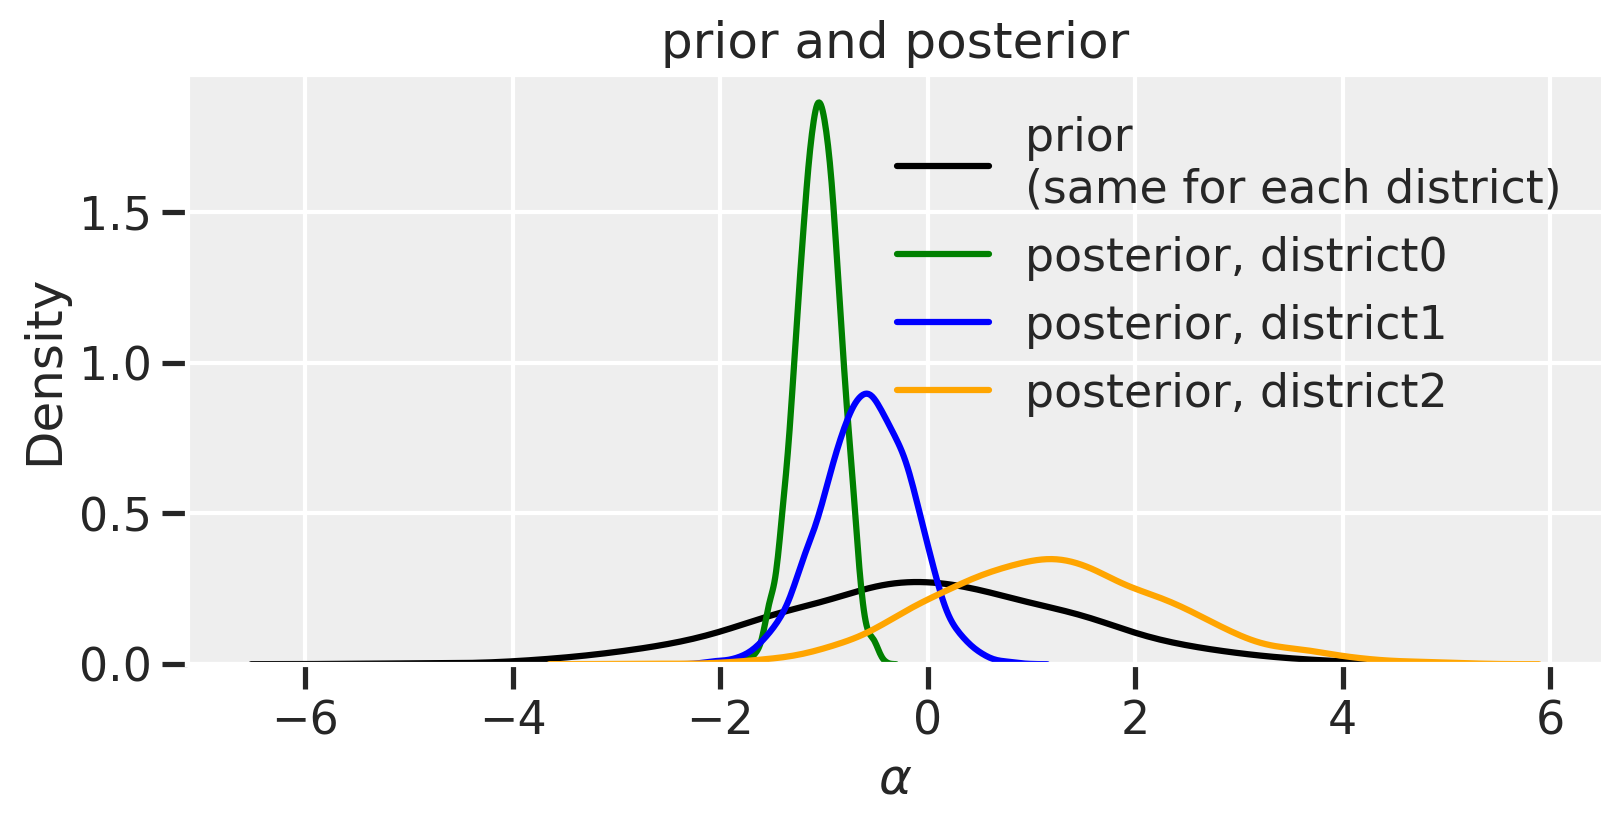

<IPython.core.display.Javascript object>

In [50]:
f, ax1 = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.kdeplot(stats.norm.rvs(0, 1.5, 1000), ax=ax1, color='black', label='prior \n(same for each district)')

sns.kdeplot(trace_mfe_df[('posterior', 'a[0]', 0)], ax=ax1, color='green', label='posterior, district0')
sns.kdeplot(trace_mfe_df[('posterior', 'a[1]', 1)], ax=ax1, color='blue', label='posterior, district1')
sns.kdeplot(trace_mfe_df[('posterior', 'a[2]', 2)], ax=ax1, color='orange', label='posterior, district2')

ax1.set(xlabel = r'$\alpha$', title='prior and posterior')
ax1.legend()

For a mixed effects model, the prior for a district *changes* depending on the observed data. I think this point is easier to understand if we think about how we add information for an indivdual instead of doing all the updating at once.

Let's examine our equations once again for the mixed model. We have two new components, an "alpha bar" and a "sigma" term now. $\bar{\alpha}$ is a parameter that represents an average for the population while $\sigma$ represents the standard deviation for the population. One wrinkle compared to the last post is that we'll need a much tighter prior for $\sigma$ compared to our last post. This is for two reasons, according to pages 407 and 408 of Statistical Rethinking. First, when we constrained the dataframe to just three districts, we also reduced the amount of data to get a suitable variance estimate. Second, we're using a log link function, which is susceptible to extreme variance values if priors are too weak. As such, instead of an $\text{Exponential}(1)$ distribution for sigma, we will use a $\text{HalfNormal}(0.1)$ distribution instead.

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{regularizing hyperprior}$$

$$\sigma \sim \text{HalfNormal}(0.1) \tag{regularizing hyperprior}$$

We can plot the hyperpriors below. The third subplot below is a reminder that the two distributions feed into the top line as our prior for each district, $\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma)$, which evokes a beautiful setting sun.

[Text(0.5, 0, 'samples of $\\bar{\\alpha}$'),
 Text(0, 0.5, 'samples of $\\sigma$'),
 Text(0.5, 1.0, 'prior distribution of\npopulation parameters')]

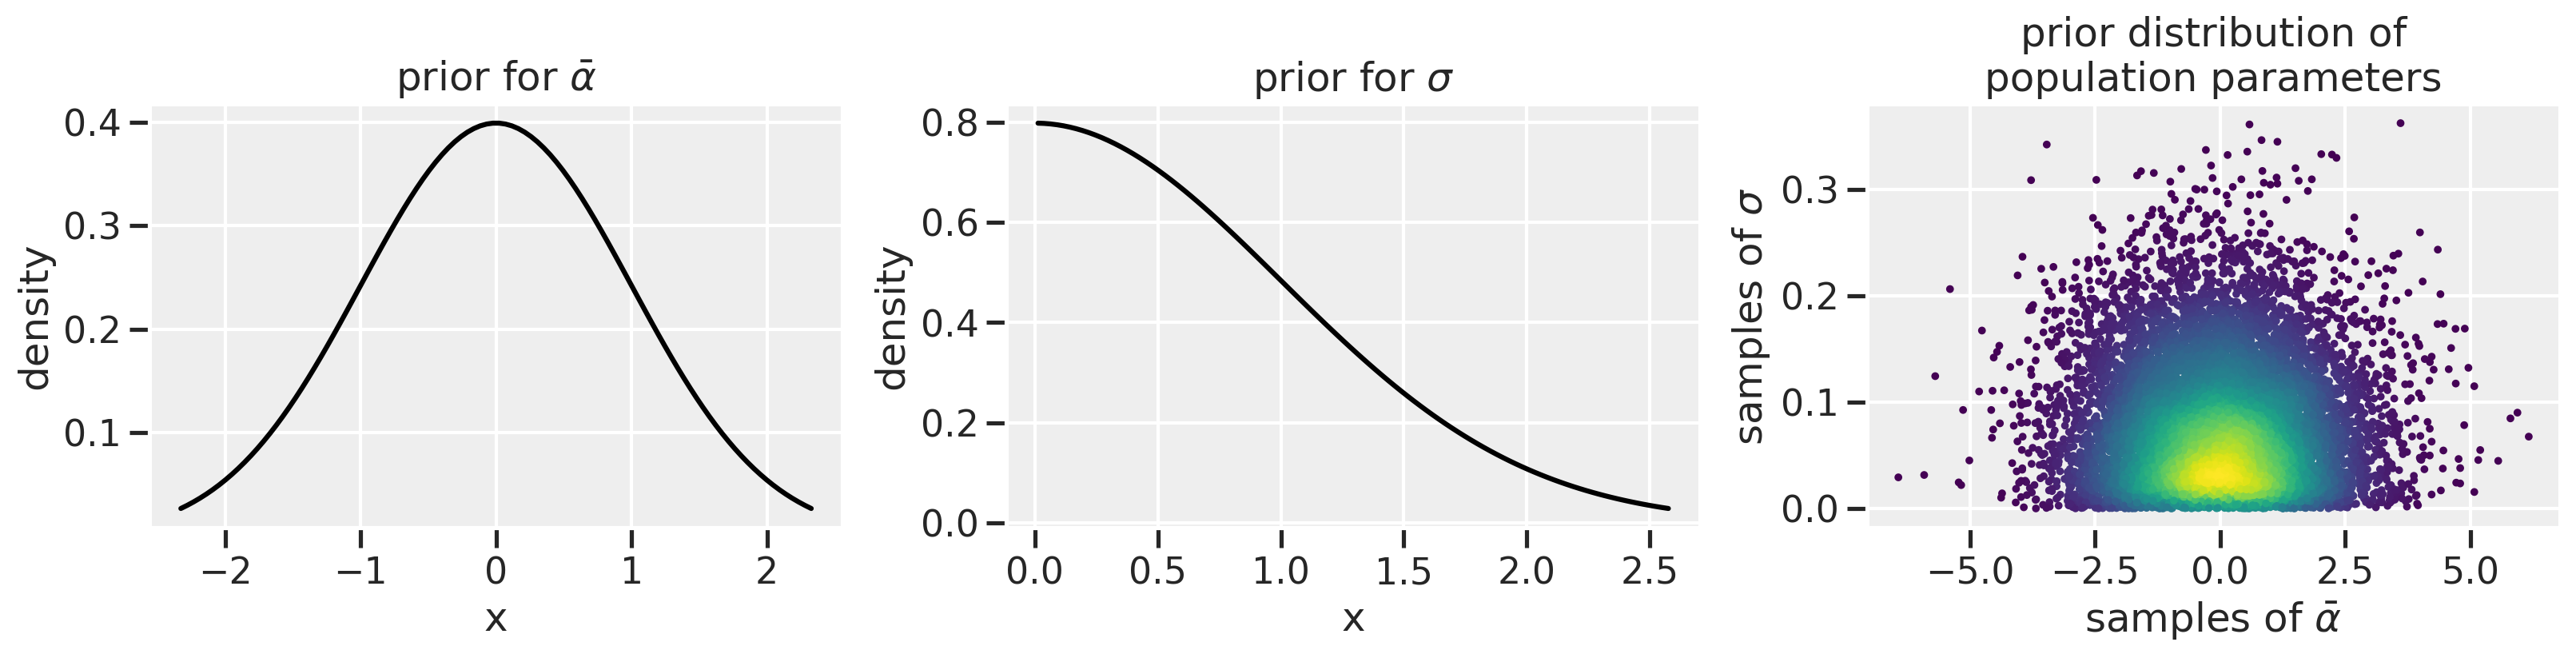

<IPython.core.display.Javascript object>

In [272]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# First two subplots ------------------------------------------
x1 = np.linspace(stats.norm.ppf(0.01),
                stats.norm.ppf(0.99), 100)
x2 = np.linspace(stats.halfnorm.ppf(0.01),
                stats.halfnorm.ppf(0.99), 100)

ax1.plot(x1, stats.norm.pdf(x1), color='black')
ax1.set(title=r'prior for $\bar{\alpha}$', xlabel = 'x', ylabel='density')
ax2.plot(x2, stats.halfnorm.pdf(x2), color='black')
ax2.set(title=r'prior for $\sigma$', xlabel = 'x', ylabel='density')


# Third subplot -----------------------------------------------
# Code to get a scatterplot colored by density
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
x = stats.norm.rvs(loc=0, scale=1.5, size=10**4)
y = stats.halfnorm.rvs(loc=0, scale=0.1, size=10**4)
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

ax3.scatter(x, y, c=z, s=2**2)
ax3.set(xlabel = r'samples of $\bar{\alpha}$', ylabel = r'samples of $\sigma$', title = 'prior distribution of\npopulation parameters')

Let's remind ourselves of two points:
1. The above plots are before we have seen any data.
2. Before we have seen any data, these priors are the *same* for all three districts in this example.

## Adding `district0` data only

Now let's imagine that we **only** have the data from `district0`, which is from 117 women, by far the largest group of the three. How do the above distributions change for each district? Since the "prior" changes to the "posterior" distribution after seeing data, I'll avoid using these terms and simply say "pre-district0 data" and "post-district0 data" to avoid ambiguity about which district's data we're including. Let's start with `district0` itself since that's the easiest to understand.

How can we get `district0`'s posterior? We can simply limit the dataframe to only include `district0` and use the machinery of `pymc` to provide it for us.

In [203]:
df_bangladesh_first3_first3_dist0 = df_bangladesh_first3[df_bangladesh_first3["district_code"]==0].copy()

with pm.Model() as mme_dist0:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # alpha prior, we only have 1 district
    a = pm.Normal("a", a_bar, sigma) # shape=len(df_bangladesh_first3["district_code"].unique()))

    # link function, only one district
    p = pm.math.invlogit(a)

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_first3_dist0["use.contraception"])

    trace_mme_dist0 = pm.sample(draws=1000, random_seed=19, target_accept=0.99, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3

<IPython.core.display.Javascript object>

We have some warnings about divergences that do not go completely away but was mitigated after changing `target_accept`. I'd go through the effort of re-paramaterizing normally but I'll use these results to keep moving forward with this demonstration.

In [204]:
az.summary(trace_mme_dist0)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-1.041,0.229,-1.388,-0.659,0.007,0.005,967.0,967.0,976.0,1061.0,1.00
a,-1.044,0.205,-1.395,-0.742,0.006,0.005,1002.0,1002.0,1003.0,963.0,1.00
sigma,0.083,0.059,0.006,0.161,0.002,0.002,669.0,669.0,514.0,500.0,1.01


<IPython.core.display.Javascript object>

<ipython-input-227-4e3454990cec>:30: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


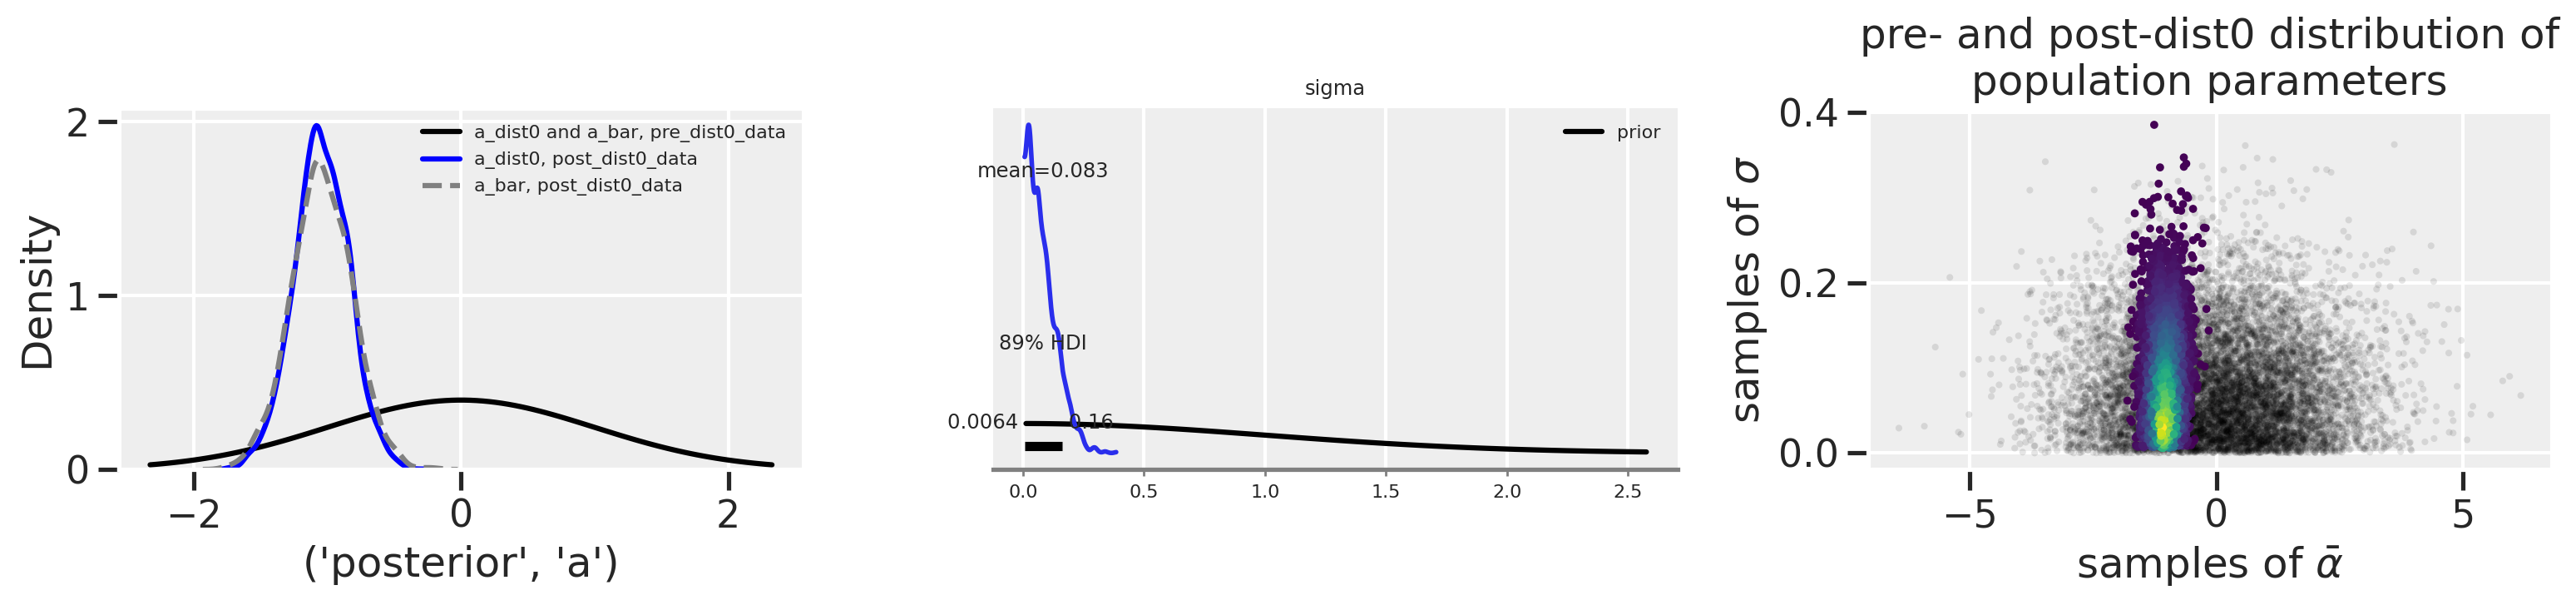

<IPython.core.display.Javascript object>

In [227]:
trace_mme_dist0_df = trace_mme_dist0.to_dataframe()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(x1, stats.norm.pdf(x1), color='black', label='a_dist0 and a_bar, pre_dist0_data')
sns.kdeplot(trace_mme_dist0_df[('posterior', 'a')], ax=ax1, color='blue', label='a_dist0, post_dist0_data')
sns.kdeplot(trace_mme_dist0_df[('posterior', 'a_bar')], ax=ax1, color='gray', linestyle='dashed', label='a_bar, post_dist0_data')
ax1.legend(fontsize=8)

ax2.plot(x2, stats.halfnorm.pdf(x2), color='black', label='prior')
#sns.kdeplot(trace_mme_dist0_df[('posterior', 'sigma')], ax=ax2, color='blue', label='sigma, post_dist0_data')
az.plot_posterior(trace_mme_dist0, var_names='sigma', linewidth=2,  textsize=8, ax=ax2) #, backend_kwargs={'label' : 'posterior'})
# ax2.set(title=r'prior for $\sigma$', xlabel = 'x', ylabel='density')
ax2.legend(fontsize=8)

# Third subplot
x_postdist0 = trace_mme_dist0_df[('posterior', 'a_bar')]
y_postdist0 = trace_mme_dist0_df[('posterior', 'sigma')]

# Calculate the point density
xy_postdist0 = np.vstack([x_postdist0,y_postdist0])
z_postdist0 = gaussian_kde(xy_postdist0)(xy_postdist0)

ax3.scatter(x, y, facecolors='none', edgecolors='black', alpha=0.1, s=2**1, label='prior')   # initial posterior
ax3.scatter(x_postdist0, y_postdist0, c=z_postdist0, s=2**2, label='posterior')   # initial posterior
ax3.set(xlabel = r'samples of $\bar{\alpha}$', ylabel = r'samples of $\sigma$')
ax3.set_title('pre- and post-dist0 distribution of\npopulation parameters')
# ax4.legend()

plt.tight_layout()

## Adding `district2` data only

In the above example, we're able to see how much the parameter distribution changes for `a_dist0`, `a_bar`, and `sigma`. Since this only includes data from one cluster, then we can think of this new distribution as serving as a prior for the other two districts. But before we add in data, let's go back to assuming no data has been included and consider the other extreme case.

In contrast to an n of 117 in `district0`, `district2` only has two women for which we have data. We should expect a much milder shift in the parameters after including `district2` data. The strategy for adding in the two datapoints from `district2` will be the same for `district0`.

In [231]:
df_bangladesh_first3_dist2 = df_bangladesh_first3[df_bangladesh_first3["district_code"]==2].copy()

with pm.Model() as mme_dist2:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # alpha prior, we only have 1 district
    a = pm.Normal("a", a_bar, sigma) # shape=len(df_bangladesh_first3["district_code"].unique()))

    # link function, only one district
    p = pm.math.invlogit(a)

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_first3_dist2["use.contraception"])

    trace_mme_dist2 = pm.sample(draws=1000, random_seed=19, target_accept=0.99, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:

<IPython.core.display.Javascript object>

Again, we have some warnings about divergences but let's keep moving forward.

In [232]:
az.summary(trace_mme_dist2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,1.227,1.197,-0.577,3.183,0.046,0.033,677.0,677.0,682.0,886.0,1.00
a,1.231,1.194,-0.601,3.144,0.046,0.032,683.0,683.0,688.0,883.0,1.00
sigma,0.084,0.057,0.006,0.161,0.002,0.002,712.0,712.0,602.0,540.0,1.01


<IPython.core.display.Javascript object>

<ipython-input-233-59a80dc5bd66>:27: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


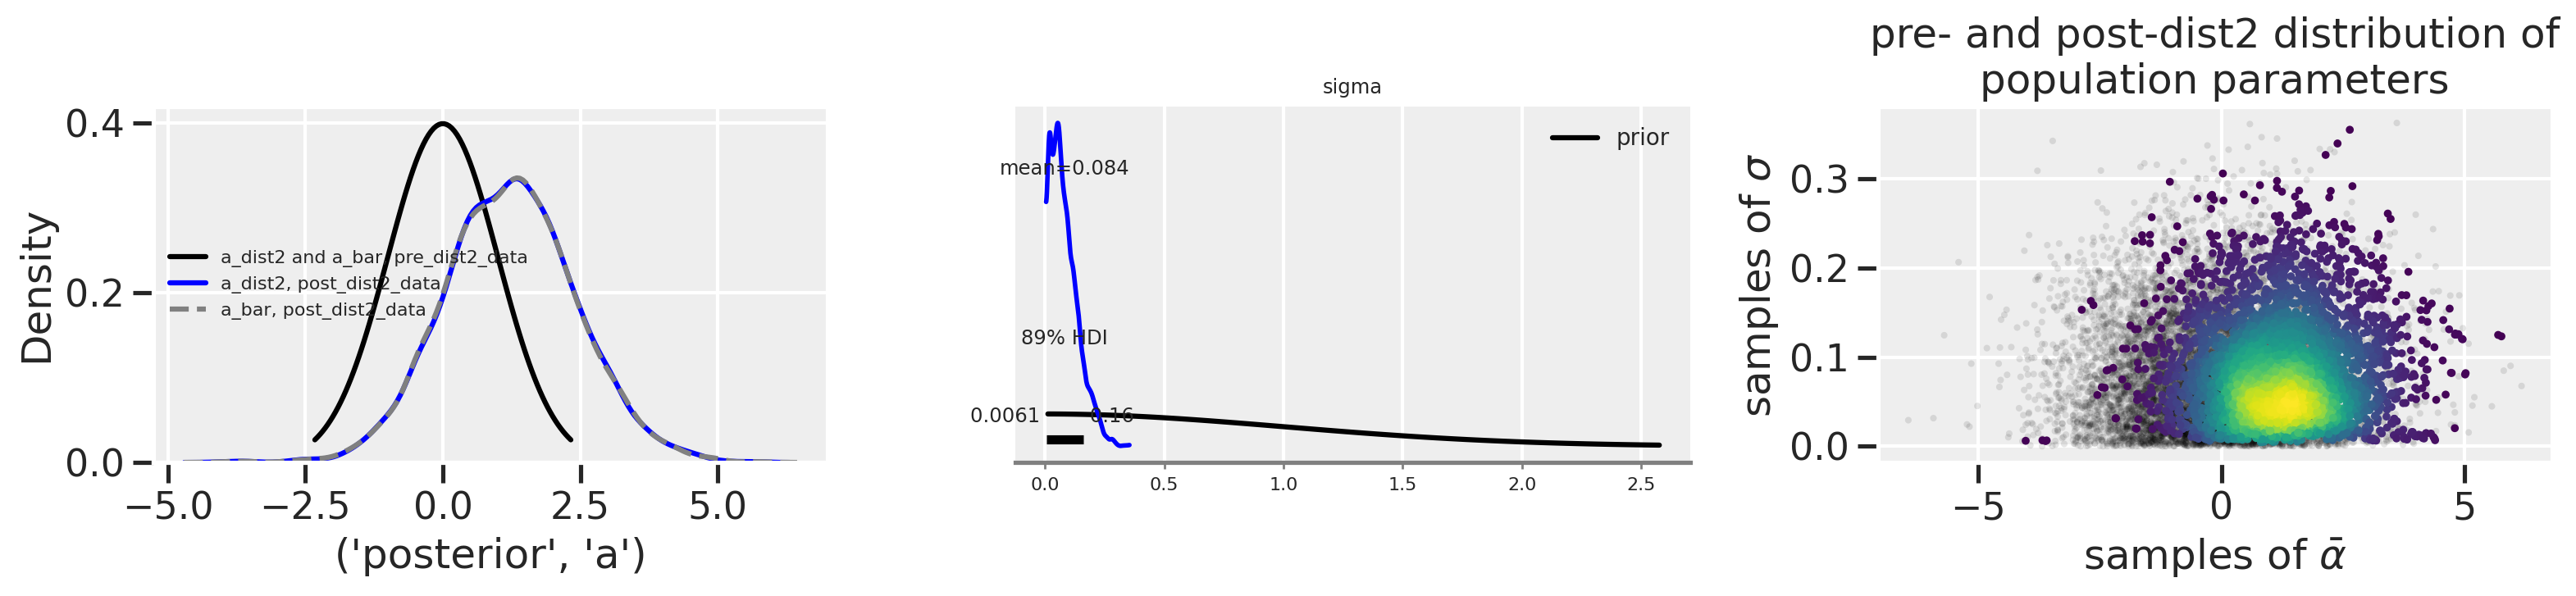

<IPython.core.display.Javascript object>

In [233]:
trace_mme_dist2_df = trace_mme_dist2.to_dataframe()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(x1, stats.norm.pdf(x1), color='black', label='a_dist2 and a_bar, pre_dist2_data')
sns.kdeplot(trace_mme_dist2_df[('posterior', 'a')], ax=ax1, color='blue', alpha=0.5, label='a_dist2, post_dist2_data')
sns.kdeplot(trace_mme_dist2_df[('posterior', 'a_bar')], ax=ax1, color='gray', alpha=0.5, linestyle='dashed', label='a_bar, post_dist2_data')
ax1.legend(fontsize=8)

ax2.plot(x2, stats.halfnorm.pdf(x2), color='black', label='prior')
az.plot_posterior(trace_mme_dist2, var_names='sigma', color='blue', linewidth=2,  textsize=8, ax=ax2)
ax2.legend(fontsize=10)

# Third subplot
x_postdist2 = trace_mme_dist2_df[('posterior', 'a_bar')]
y_postdist2 = trace_mme_dist2_df[('posterior', 'sigma')]

# Calculate the point density
xy_postdist2 = np.vstack([x_postdist2,y_postdist2])
z_postdist2 = gaussian_kde(xy_postdist2)(xy_postdist2)

ax3.scatter(x, y, facecolors='none', edgecolors='black', alpha=0.1, s=2**1, label='prior')   # initial posterior
ax3.scatter(x_postdist2, y_postdist2, c=z_postdist2, s=2**2, label='posterior')   # initial posterior
ax3.set(xlabel = r'samples of $\bar{\alpha}$', ylabel = r'samples of $\sigma$')
ax3.set_title('pre- and post-dist2 distribution of\npopulation parameters')

plt.tight_layout()

In [228]:
df_bangladesh_dist2

,woman,district,use.contraception,living.children,age.centered,urban,district_code
137,138,3,1,4,-3.5599,1,2
138,139,3,1,1,-8.5599,1,2


<IPython.core.display.Javascript object>

We see a shift and we can make observations compared to when adding the `district0` data only. First, the shift of `a_bar` and `a_dist2` is rightward, meaning slightly higher log-odds for using contraception. This makes sense since both women in this district used contraception. A second observation is that, because there were only two women, the `a_bar` shift is much more mild compared to how `district0` influenced the parameters' distribution.

In the examples thus far, we have only looked at the impact of adding data from one district at a time. Because of this, we see the posterior distribution of `a_bar` track very similarly with `a` for the district we're looking at.

Of course, the power of multilevel models is the ability to update all paramaters at once. Let's do this now.

## Including data from all three districts

In [234]:
with pm.Model() as mme_distall:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # alpha prior, we now account for all 3 districts
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh_first3["district_code"].unique()))

    # link function, all districts
    p = pm.math.invlogit(a[df_bangladesh_first3["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_first3["use.contraception"])

    trace_mme_distall = pm.sample(draws=1000, random_seed=19, target_accept=0.99, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:

<IPython.core.display.Javascript object>

In [235]:
az.summary(trace_mme_distall)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.924,0.205,-1.244,-0.597,0.009,0.006,571.0,542.0,573.0,517.0,1.00
a[0],-0.952,0.186,-1.260,-0.661,0.007,0.005,640.0,613.0,650.0,662.0,1.00
a[1],-0.917,0.220,-1.244,-0.557,0.009,0.007,600.0,567.0,601.0,608.0,1.00
a[2],-0.911,0.230,-1.269,-0.548,0.010,0.007,585.0,567.0,578.0,649.0,1.00
sigma,0.081,0.059,0.004,0.161,0.003,0.002,346.0,346.0,286.0,532.0,1.02


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

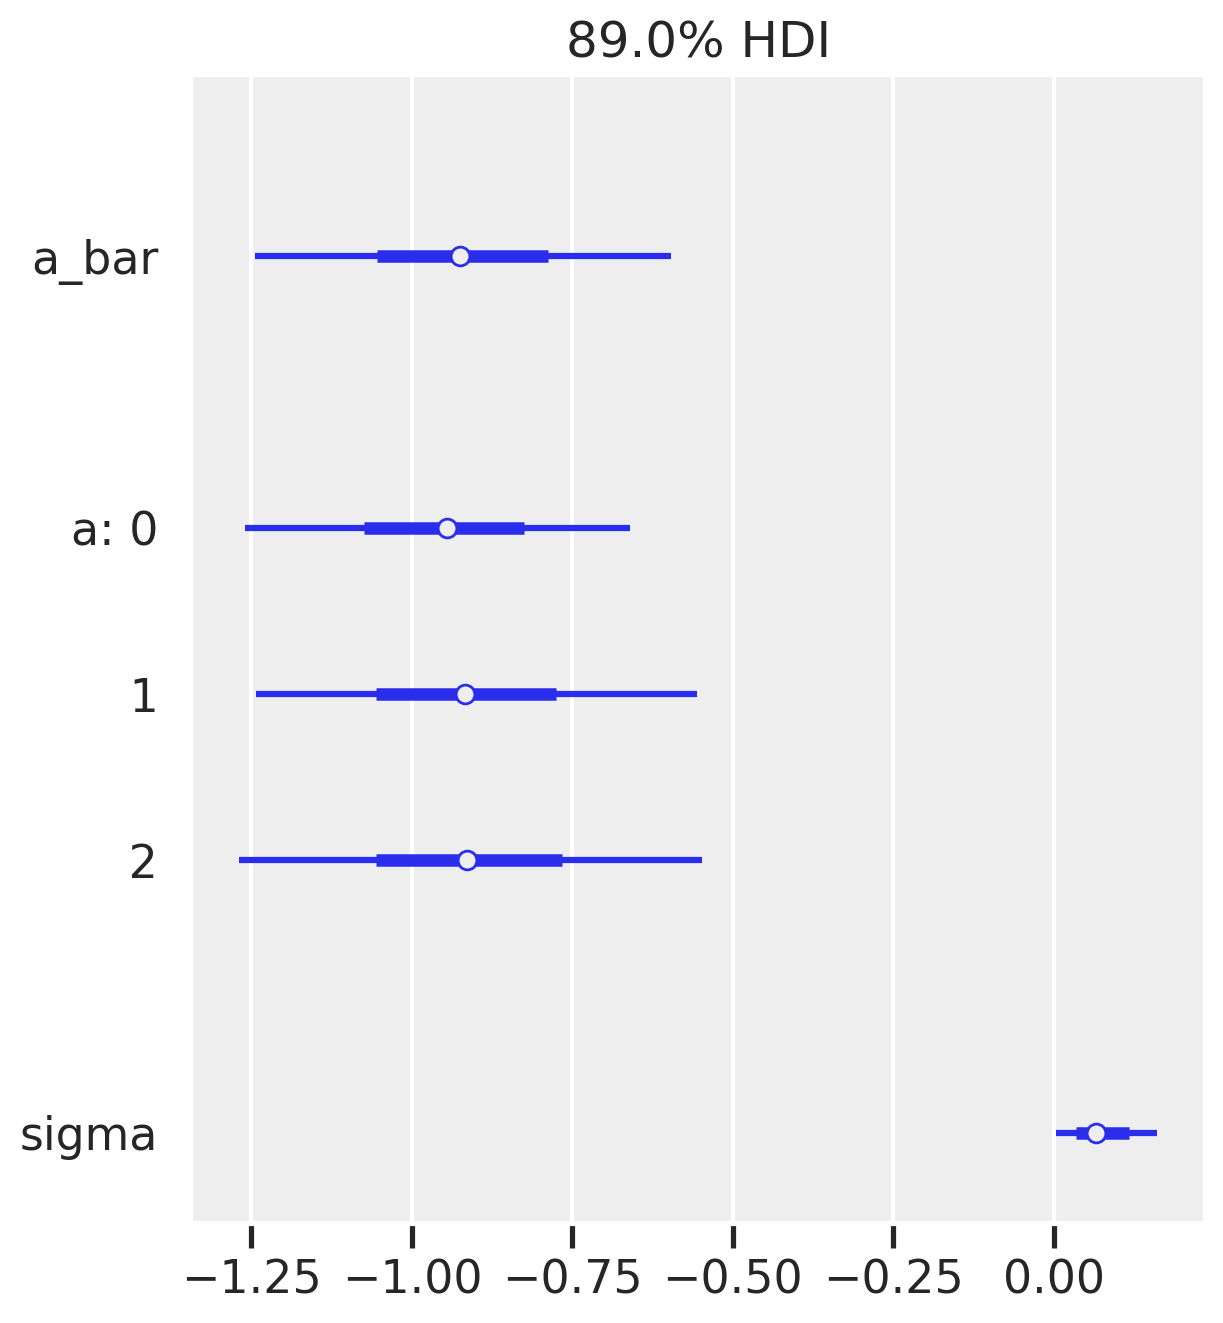

<IPython.core.display.Javascript object>

In [273]:
az.plot_forest(trace_mme_distall, combined=True)

<ipython-input-239-7a1226400ba0>:29: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


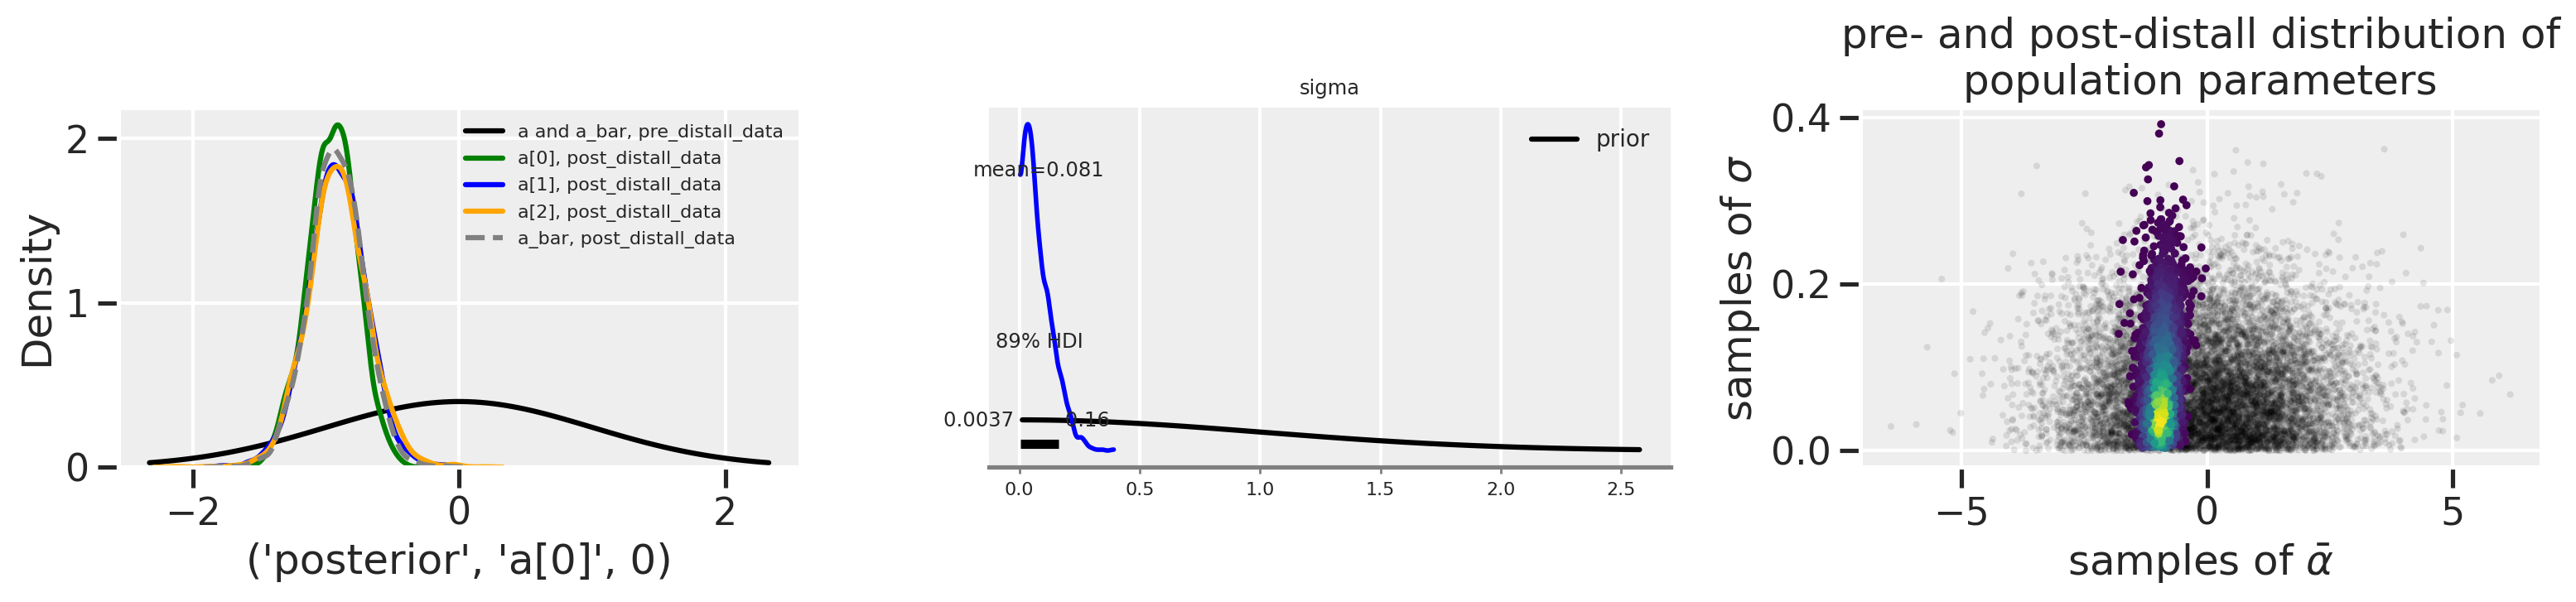

<IPython.core.display.Javascript object>

In [239]:
trace_mme_distall_df = trace_mme_distall.to_dataframe()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(x1, stats.norm.pdf(x1), color='black', label='a and a_bar, pre_distall_data')
sns.kdeplot(trace_mme_distall_df[('posterior', 'a[0]', 0)], ax=ax1, color='green', alpha=0.5, label='a[0], post_distall_data')
sns.kdeplot(trace_mme_distall_df[('posterior', 'a[1]', 1)], ax=ax1, color='blue', alpha=0.5, label='a[1], post_distall_data')
sns.kdeplot(trace_mme_distall_df[('posterior', 'a[2]', 2)], ax=ax1, color='orange', alpha=0.5, label='a[2], post_distall_data')
sns.kdeplot(trace_mme_distall_df[('posterior', 'a_bar')], ax=ax1, color='gray', alpha=0.5, linestyle='dashed', label='a_bar, post_distall_data')
ax1.legend(fontsize=8)

ax2.plot(x2, stats.halfnorm.pdf(x2), color='black', label='prior')
az.plot_posterior(trace_mme_distall, var_names='sigma', color='blue', linewidth=2,  textsize=8, ax=ax2)
ax2.legend(fontsize=10)

# Third subplot
x_postdistall = trace_mme_distall_df[('posterior', 'a_bar')]
y_postdistall = trace_mme_distall_df[('posterior', 'sigma')]

# Calculate the point density
xy_postdistall = np.vstack([x_postdistall,y_postdistall])
z_postdistall = gaussian_kde(xy_postdistall)(xy_postdistall)

ax3.scatter(x, y, facecolors='none', edgecolors='black', alpha=0.1, s=2**1, label='prior')   # initial posterior
ax3.scatter(x_postdistall, y_postdistall, c=z_postdistall, s=2**2, label='posterior')   # initial posterior
ax3.set(xlabel = r'samples of $\bar{\alpha}$', ylabel = r'samples of $\sigma$')
ax3.set_title('pre- and post-distall distribution of\npopulation parameters')

plt.tight_layout()

The `district0` samples are so high that it dominates `a_bar`. Let's look at districts where the counts are a little less variable.

# A more balance set of 3

We can inspect which districts are among the districts with a smaller and less variable set of women.

In [251]:
df_bangladesh["district_code"].value_counts().tail(5)

41    11
57    10
53     6
48     4
2      2
Name: district_code, dtype: int64

<IPython.core.display.Javascript object>

Let's choose district codes 41, 57, and 53. To get the model working, we can't just make another dataframe that segments data to just these districts. We also have to do another re-naming of them which is in the second line of the following code cell.

In [265]:
df_bangladesh_balanced3 = df_bangladesh[df_bangladesh['district_code'].isin([41, 57, 53])].copy()
df_bangladesh_balanced3['district_code2'] = pd.Categorical(df_bangladesh_balanced3['district']).codes
df_bangladesh_balanced3.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_code,district_code2
1334,1335,42,0,2,-7.5599,1,41,0
1335,1336,42,1,2,-2.5599,1,41,0
1336,1337,42,0,1,-13.5590,1,41,0
1337,1338,42,0,2,0.4400,1,41,0
1338,1339,42,0,2,-0.5599,1,41,0


<IPython.core.display.Javascript object>

In [271]:
df_bangladesh_balanced3.groupby('district_code2').mean()

,woman,district,use.contraception,living.children,age.centered,urban,district_code
district_code2,,,,,,,
0,1340.0,42.0,0.545455,2.272727,0.258309,0.454545,41
1,1742.5,55.0,0.166667,2.666667,5.273350,1.000000,53
2,1855.5,59.0,0.100000,2.800000,-3.359870,0.000000,57


<IPython.core.display.Javascript object>

Here you can see how the code gets remapped to variables `0`, `1`, and `2` for use in `pymc`.

In [266]:
df_bangladesh_balanced3[['district_code', 'district_code2']].drop_duplicates()

,district_code,district_code2
1334,41,0
1739,53,1
1850,57,2


<IPython.core.display.Javascript object>

Now let's run the model with this new set of data.

In [267]:
with pm.Model() as mme_distbal3:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # alpha prior
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh_balanced3["district_code2"].unique()))

    # link function, all districts
    p = pm.math.invlogit(a[df_bangladesh_balanced3["district_code2"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_balanced3["use.contraception"])

    trace_mme_distbal3 = pm.sample(draws=1000, random_seed=19, target_accept=0.99, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There 

<IPython.core.display.Javascript object>

In [268]:
az.summary(trace_mme_distbal3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.877,0.414,-1.534,-0.257,0.018,0.014,516.0,462.0,528.0,492.0,1.01
a[0],-0.847,0.419,-1.491,-0.186,0.018,0.014,517.0,465.0,528.0,465.0,1.01
a[1],-0.891,0.421,-1.560,-0.235,0.018,0.014,531.0,477.0,540.0,511.0,1.01
a[2],-0.901,0.417,-1.521,-0.222,0.018,0.014,526.0,476.0,538.0,491.0,1.01
sigma,0.091,0.062,0.007,0.172,0.003,0.002,403.0,403.0,320.0,434.0,1.02


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

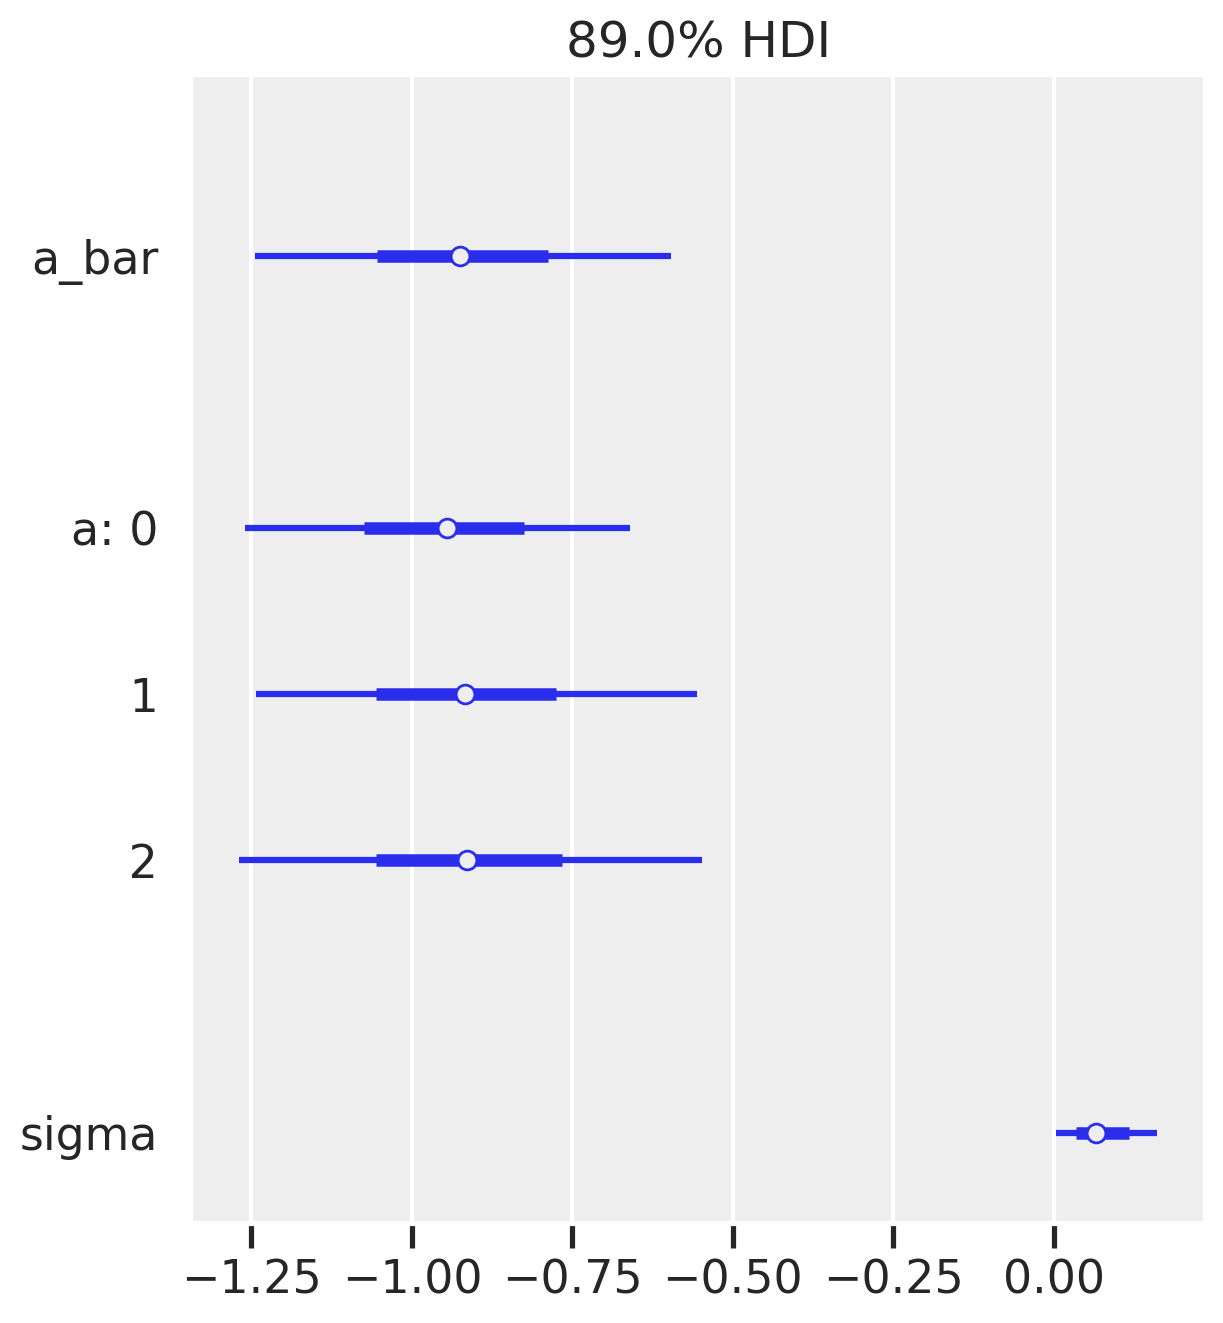

<IPython.core.display.Javascript object>

In [270]:
az.plot_forest(trace_mme_distall, combined=True)

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

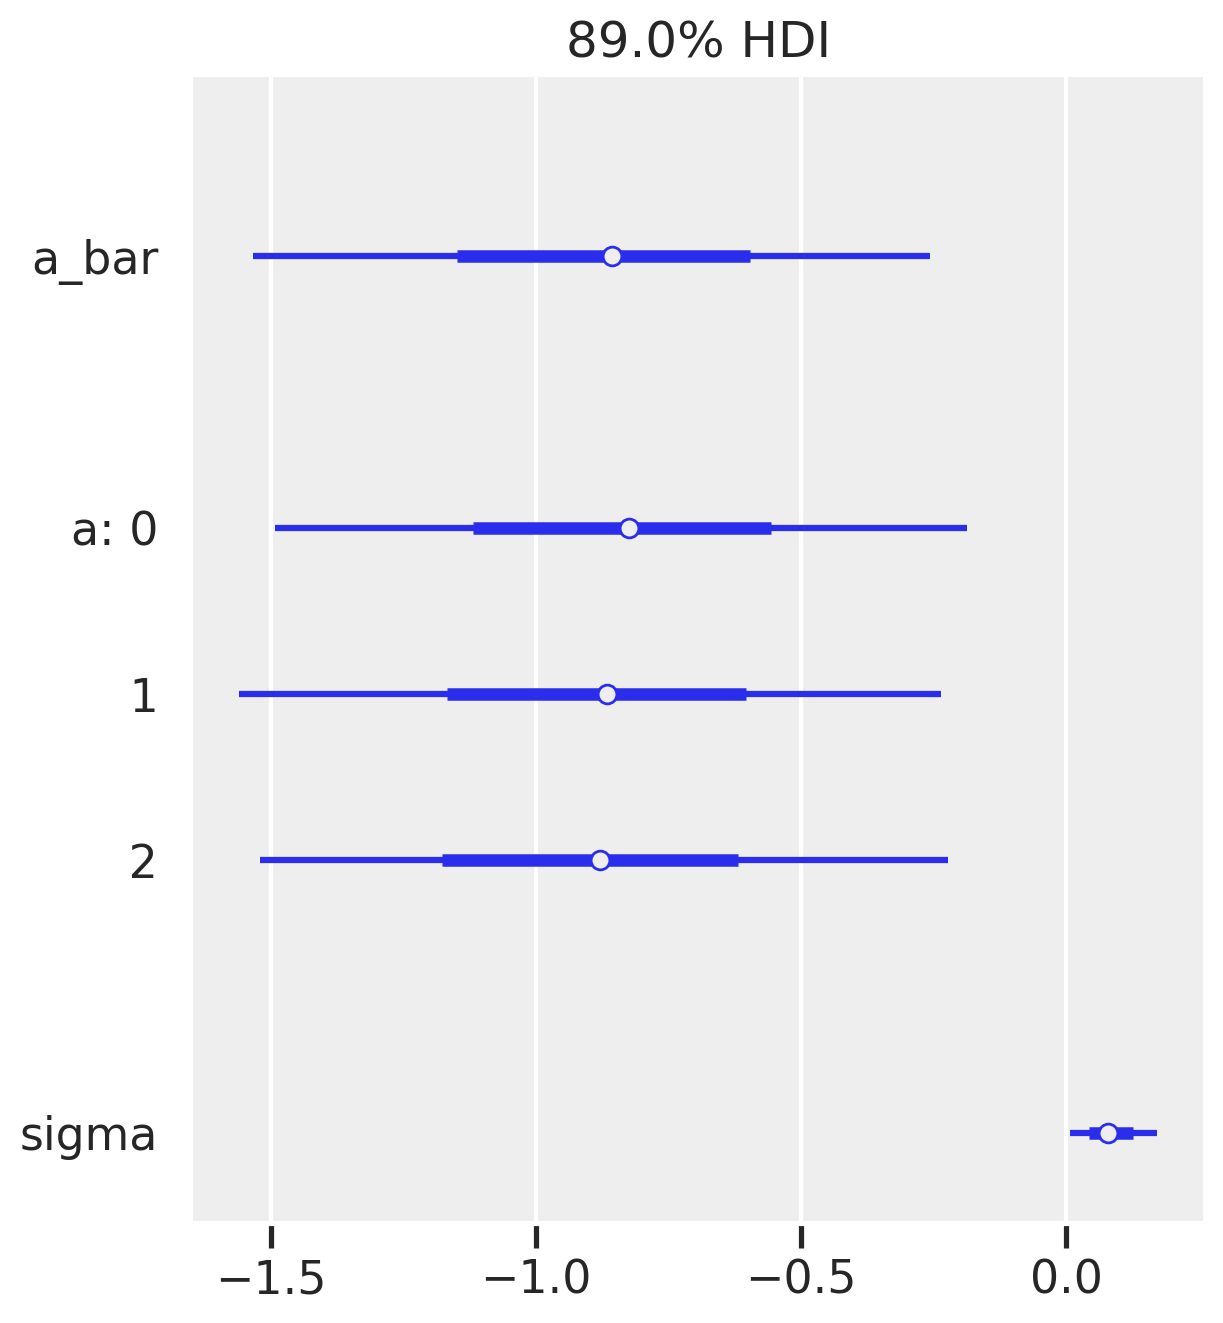

<IPython.core.display.Javascript object>

In [269]:
az.plot_forest(trace_mme_distbal3, combined=True)

Now that we have a sense for how the data is structured, we can start building our models. To appreciate the mixed-effects model, we will start by creating a fixed-effects model so that we can highlight the differences between them.

## Fixed-effects model

Predict `use.contraception`. Since there are two outcomes, it makes sense to use a binomial GLM for this problem. We'll use an index variable for district and it will be an intercept only model. We are using a binomial likelihood where each observation(n) is 1, since each row of our dataset is for one woman. Alternatively, we could have used a Bernoulli. The parameter *p* is the probability of a woman using contraception. We obtain this from the linear model which is on the second line. The linear model uses the [logit function](https://en.wikipedia.org/wiki/Logit) to serve as our link function with the binomial GLM. Finally, we have a regularizing prior for $\alpha$ so that our considered values for *p* are within reason. What $\alpha$ represents in this case is the average contraception use for each district. This is *regardless* of any other variables that are in our dataframe because we have omitted them from our model. This point will be contrasted with a future post where we build on this problem.

**Model `mfe` equation**

$$C_i \sim \text{Binomial}(1, p_i) \tag{binomial likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} \tag{linear model using logit link}$$

$$\alpha_j \sim \text{Normal}(0, 1.5) \tag{regularizing prior}$$

Now let's use `pymc` to build our model.

In [65]:
with pm.Model() as mfe:

    # alpha prior, one for each district
    a = pm.Normal("a", 0, 1.5, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mfe = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


<IPython.core.display.Javascript object>

In [66]:
# View summary of mfe model
az.summary(trace_mfe).head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.052,0.205,-1.389,-0.730,0.002,0.002,10791.0,8837.0,11082.0,2622.0,1.0
a[1],-0.584,0.452,-1.287,0.134,0.005,0.005,9885.0,4432.0,9897.0,2824.0,1.0
a[2],1.240,1.156,-0.647,2.980,0.012,0.014,8647.0,3240.0,8900.0,2517.0,1.0
a[3],-0.003,0.362,-0.572,0.579,0.004,0.007,9690.0,1409.0,9763.0,2666.0,1.0
a[4],-0.569,0.330,-1.077,-0.020,0.004,0.003,8362.0,4628.0,8431.0,2847.0,1.0


<IPython.core.display.Javascript object>

Let's visualize the posterior distributions of the $\alpha$ parameter for each district.

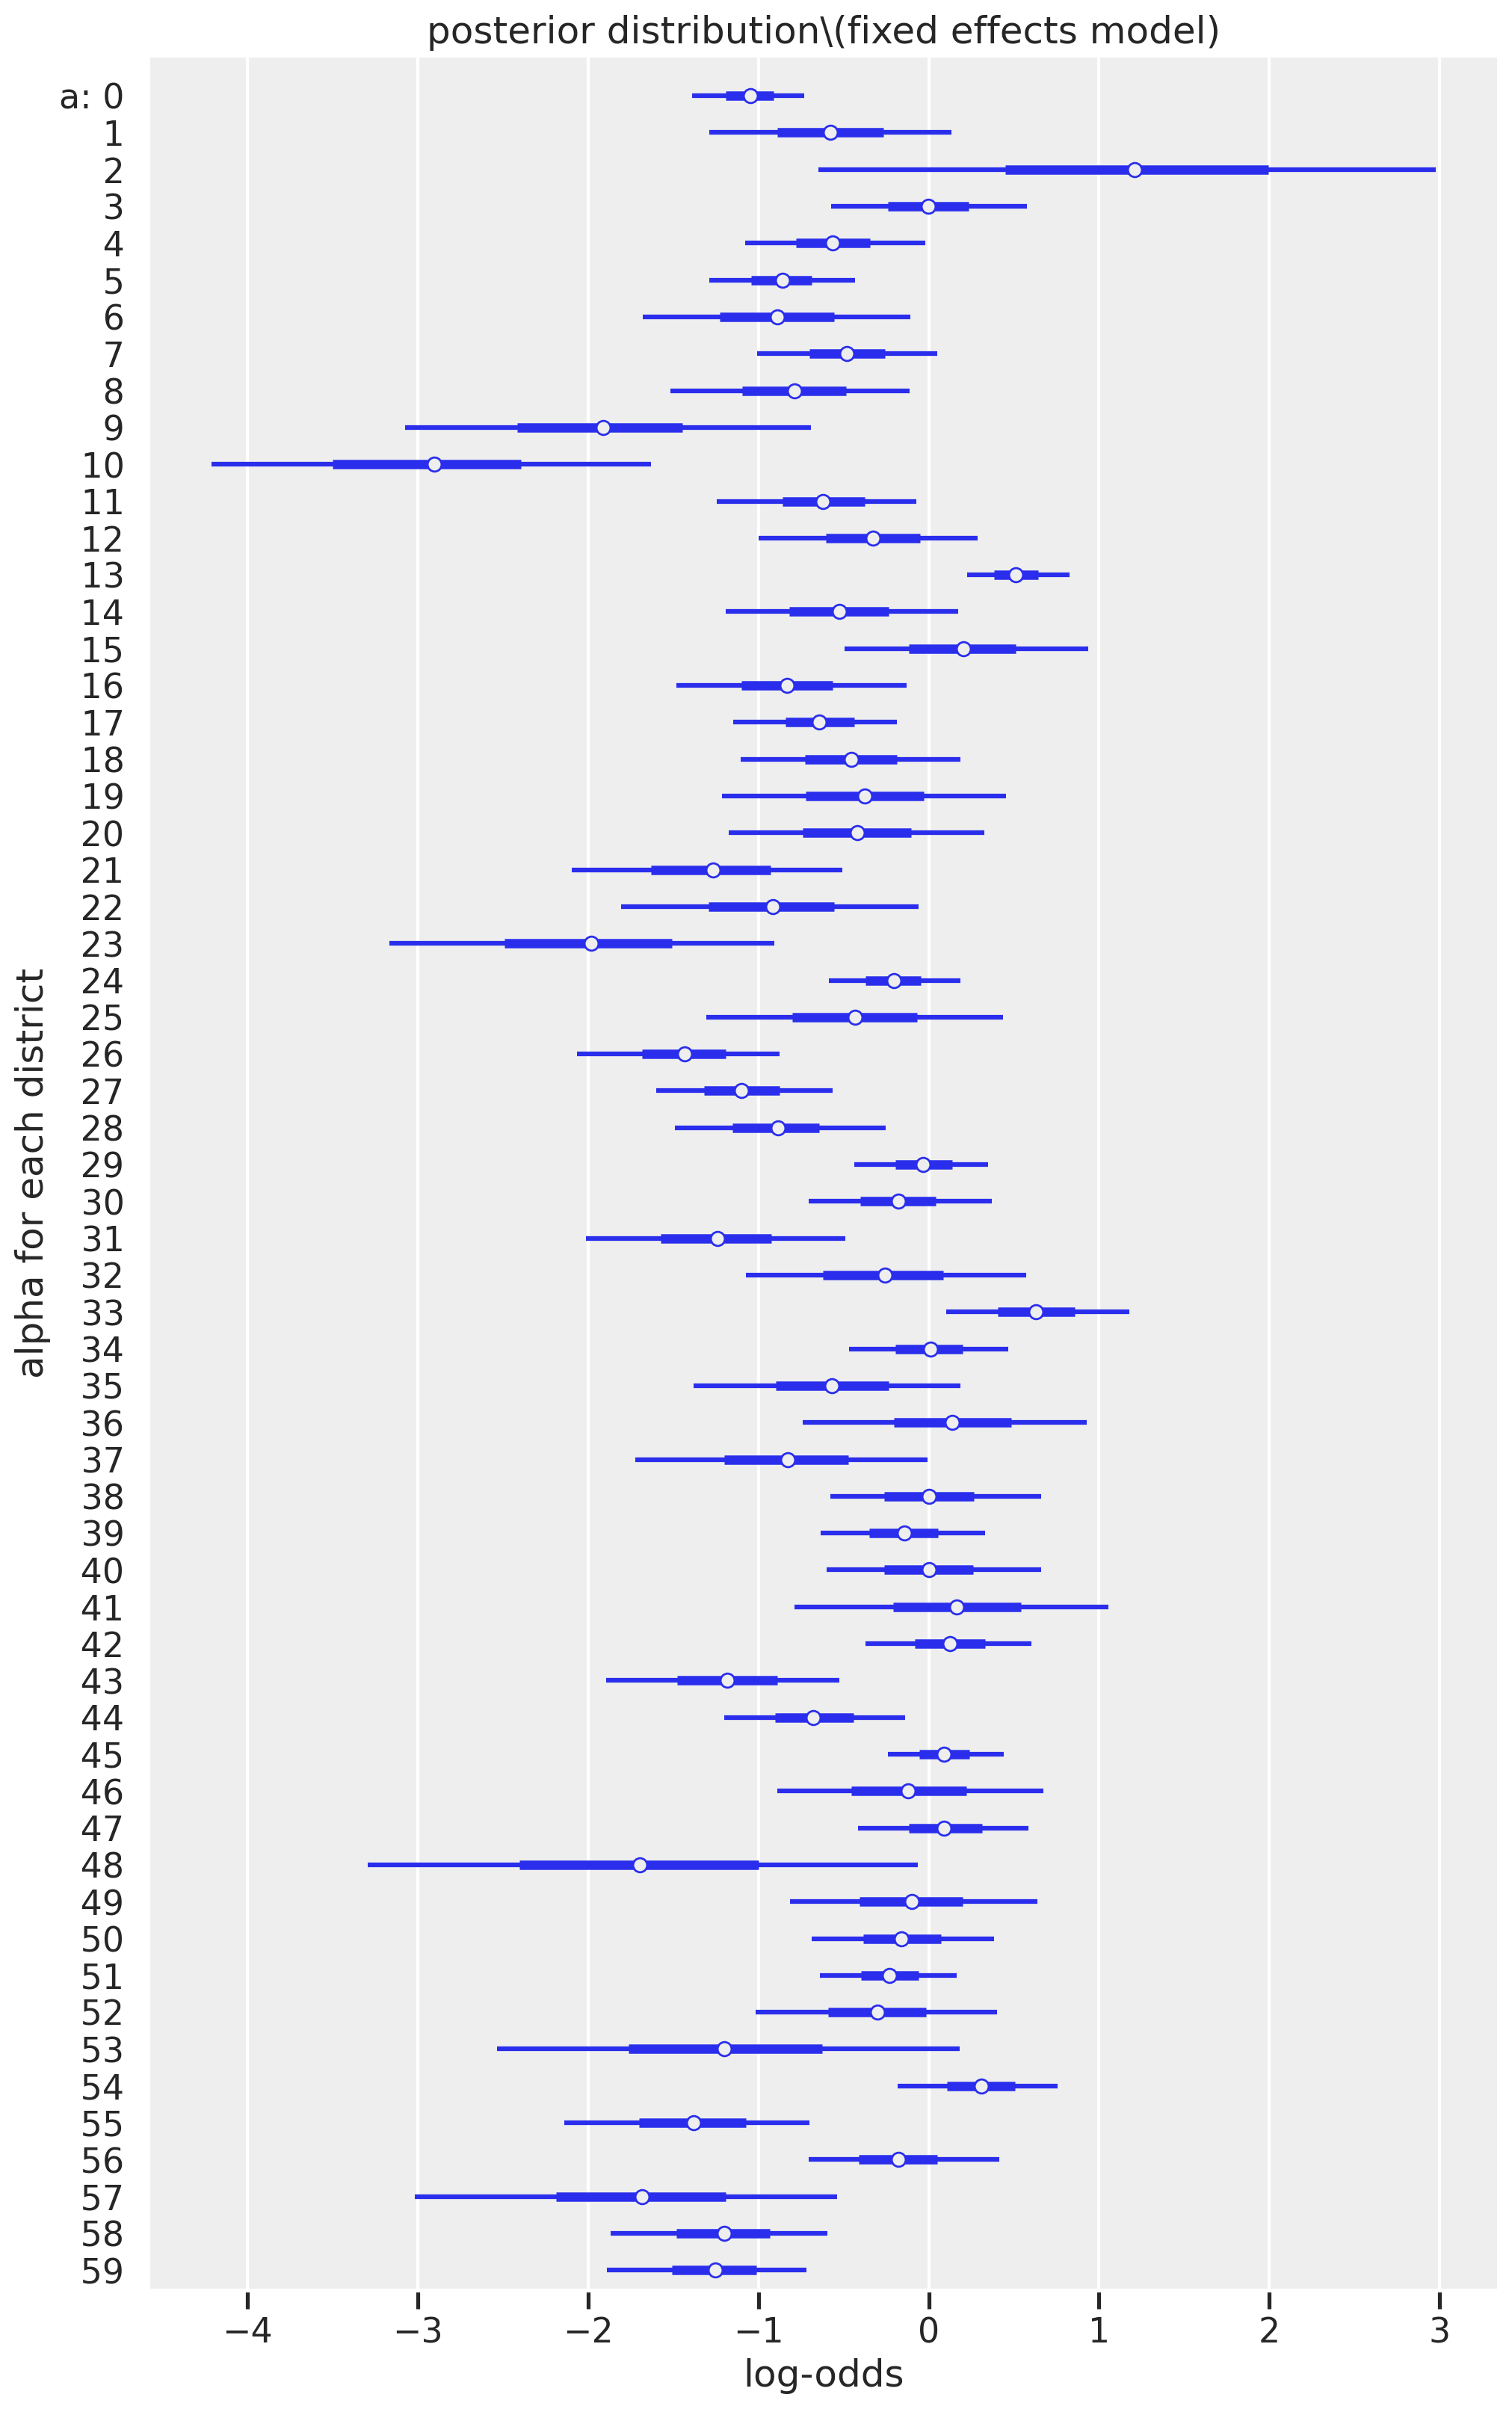

<IPython.core.display.Javascript object>

In [67]:
f, ax1 = plt.subplots(figsize=(10, 16))
az.plot_forest(trace_mfe, combined=True, ax=ax1)
ax1.set(xlabel="log-odds", ylabel="alpha for each district", title='posterior distribution\(fixed effects model)');

We can learn a lot by looking at these results. First, it is clear that some districts are much less likely to use contraception (negative log-odds) than other districts (log-odds that span zero or are wholly positive). The district indexed as 10 (originally called district 11 of the raw dataset) has the mean with the lowest likelihood of contraceptive usage; if you inspect the raw data, no woman used contraception.

In [68]:
print("No. of district index 10 women who used contraception: ", (df_bangladesh[df_bangladesh["district_code"] == 10]['use.contraception']).sum())

No. of district index 10 women who used contraception:  0


<IPython.core.display.Javascript object>

Another point worth our focus is the width of the credible intervals, representing the uncertainty of our estimate. For example, district index 2 has a mean estimate that is the most positive among all the districts, but the credible interval is exceptionally wide, ranging from a log-ods of -0.647 to 2.980. Other districts, however, have relatively narrow confidence intervals, such as district index 13. This difference in variability can be explained by the number of women in each district. Higher counts represent lower uncertainties.

In [69]:
print("Top 5 lowest districts for counts of women:\n", df_bangladesh['district_code'].value_counts().sort_values().head())

print("Top 5 highest districts for counts of women:\n", df_bangladesh['district_code'].value_counts().sort_values().tail())

Top 5 lowest districts for counts of women:
 2      2
48     4
53     6
57    10
41    11
Name: district_code, dtype: int64
Top 5 highest districts for counts of women:
 5      65
24     67
45     86
0     117
13    118
Name: district_code, dtype: int64


<IPython.core.display.Javascript object>

While the fixed-effecs model is a reasonable approach, we can do better with a multilevel (mixed-effects) model. Let's do that next.

## Mixed-effects model

Here we can allow information to pool between clusters (districts). This would make more sense since there's a varying number of women in each district as we identified above. We would expect our district index 2 estimate to be more precise (narrower credible interval).

How can information be shared? This is where the structure of our equations can give some insight. The main change is the third line in the equations below. We're now using an **adaptive prior** that borrows information from *each* district, to make better estimates for *all* districts. Instead of specifying numerical values in our prior for $\alpha_j$, we instead replace them with new parameters. These new parameters are an "average alpha", $\bar{\alpha}$ and $\sigma$ and they have their own priors, which we call a hyperprior. Seeing how we can see parameters embedded in other parameters is how we can also appreciate the "multilevel"-ness of the multilevel model. (As McElreath states in an earlier lecture, it can become parameters all the way down.)

**Model `mme` equation**

$$C_i \sim \text{Binomial}(1, p_i) \tag{binomial likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} \tag{linear model using logit link}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{regularizing hyperprior}$$

$$\sigma \sim \text{Exponential}(1) \tag{regularizing hyperprior}$$

In [70]:
# multilevel model
with pm.Model() as mme:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.Exponential("sigma", 1.0)

    # alpha priors for each district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mme = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


<IPython.core.display.Javascript object>

It looks like there are no divergences here so we don't have to worry about re-parameterizing. Let's take a look now.

In [71]:
# View summary of mme model
az.summary(trace_mme).head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.540,0.088,-0.679,-0.397,0.002,0.001,3125.0,3125.0,3125.0,3066.0,1.00
a[0],-0.992,0.198,-1.299,-0.679,0.003,0.002,5931.0,5154.0,5973.0,2419.0,1.00
a[1],-0.599,0.360,-1.144,-0.001,0.004,0.004,7047.0,3716.0,7138.0,2443.0,1.01
a[2],-0.240,0.501,-1.003,0.559,0.006,0.008,7605.0,2191.0,7501.0,3176.0,1.00
a[3],-0.179,0.298,-0.652,0.309,0.004,0.004,6683.0,2486.0,6638.0,3036.0,1.00


<IPython.core.display.Javascript object>

Let's visualize by plotting the mixed effects model posterior side-by-side with the fixed-effects model that we already visualized above. This will help us appreciate the impact of the multilevel model structure.

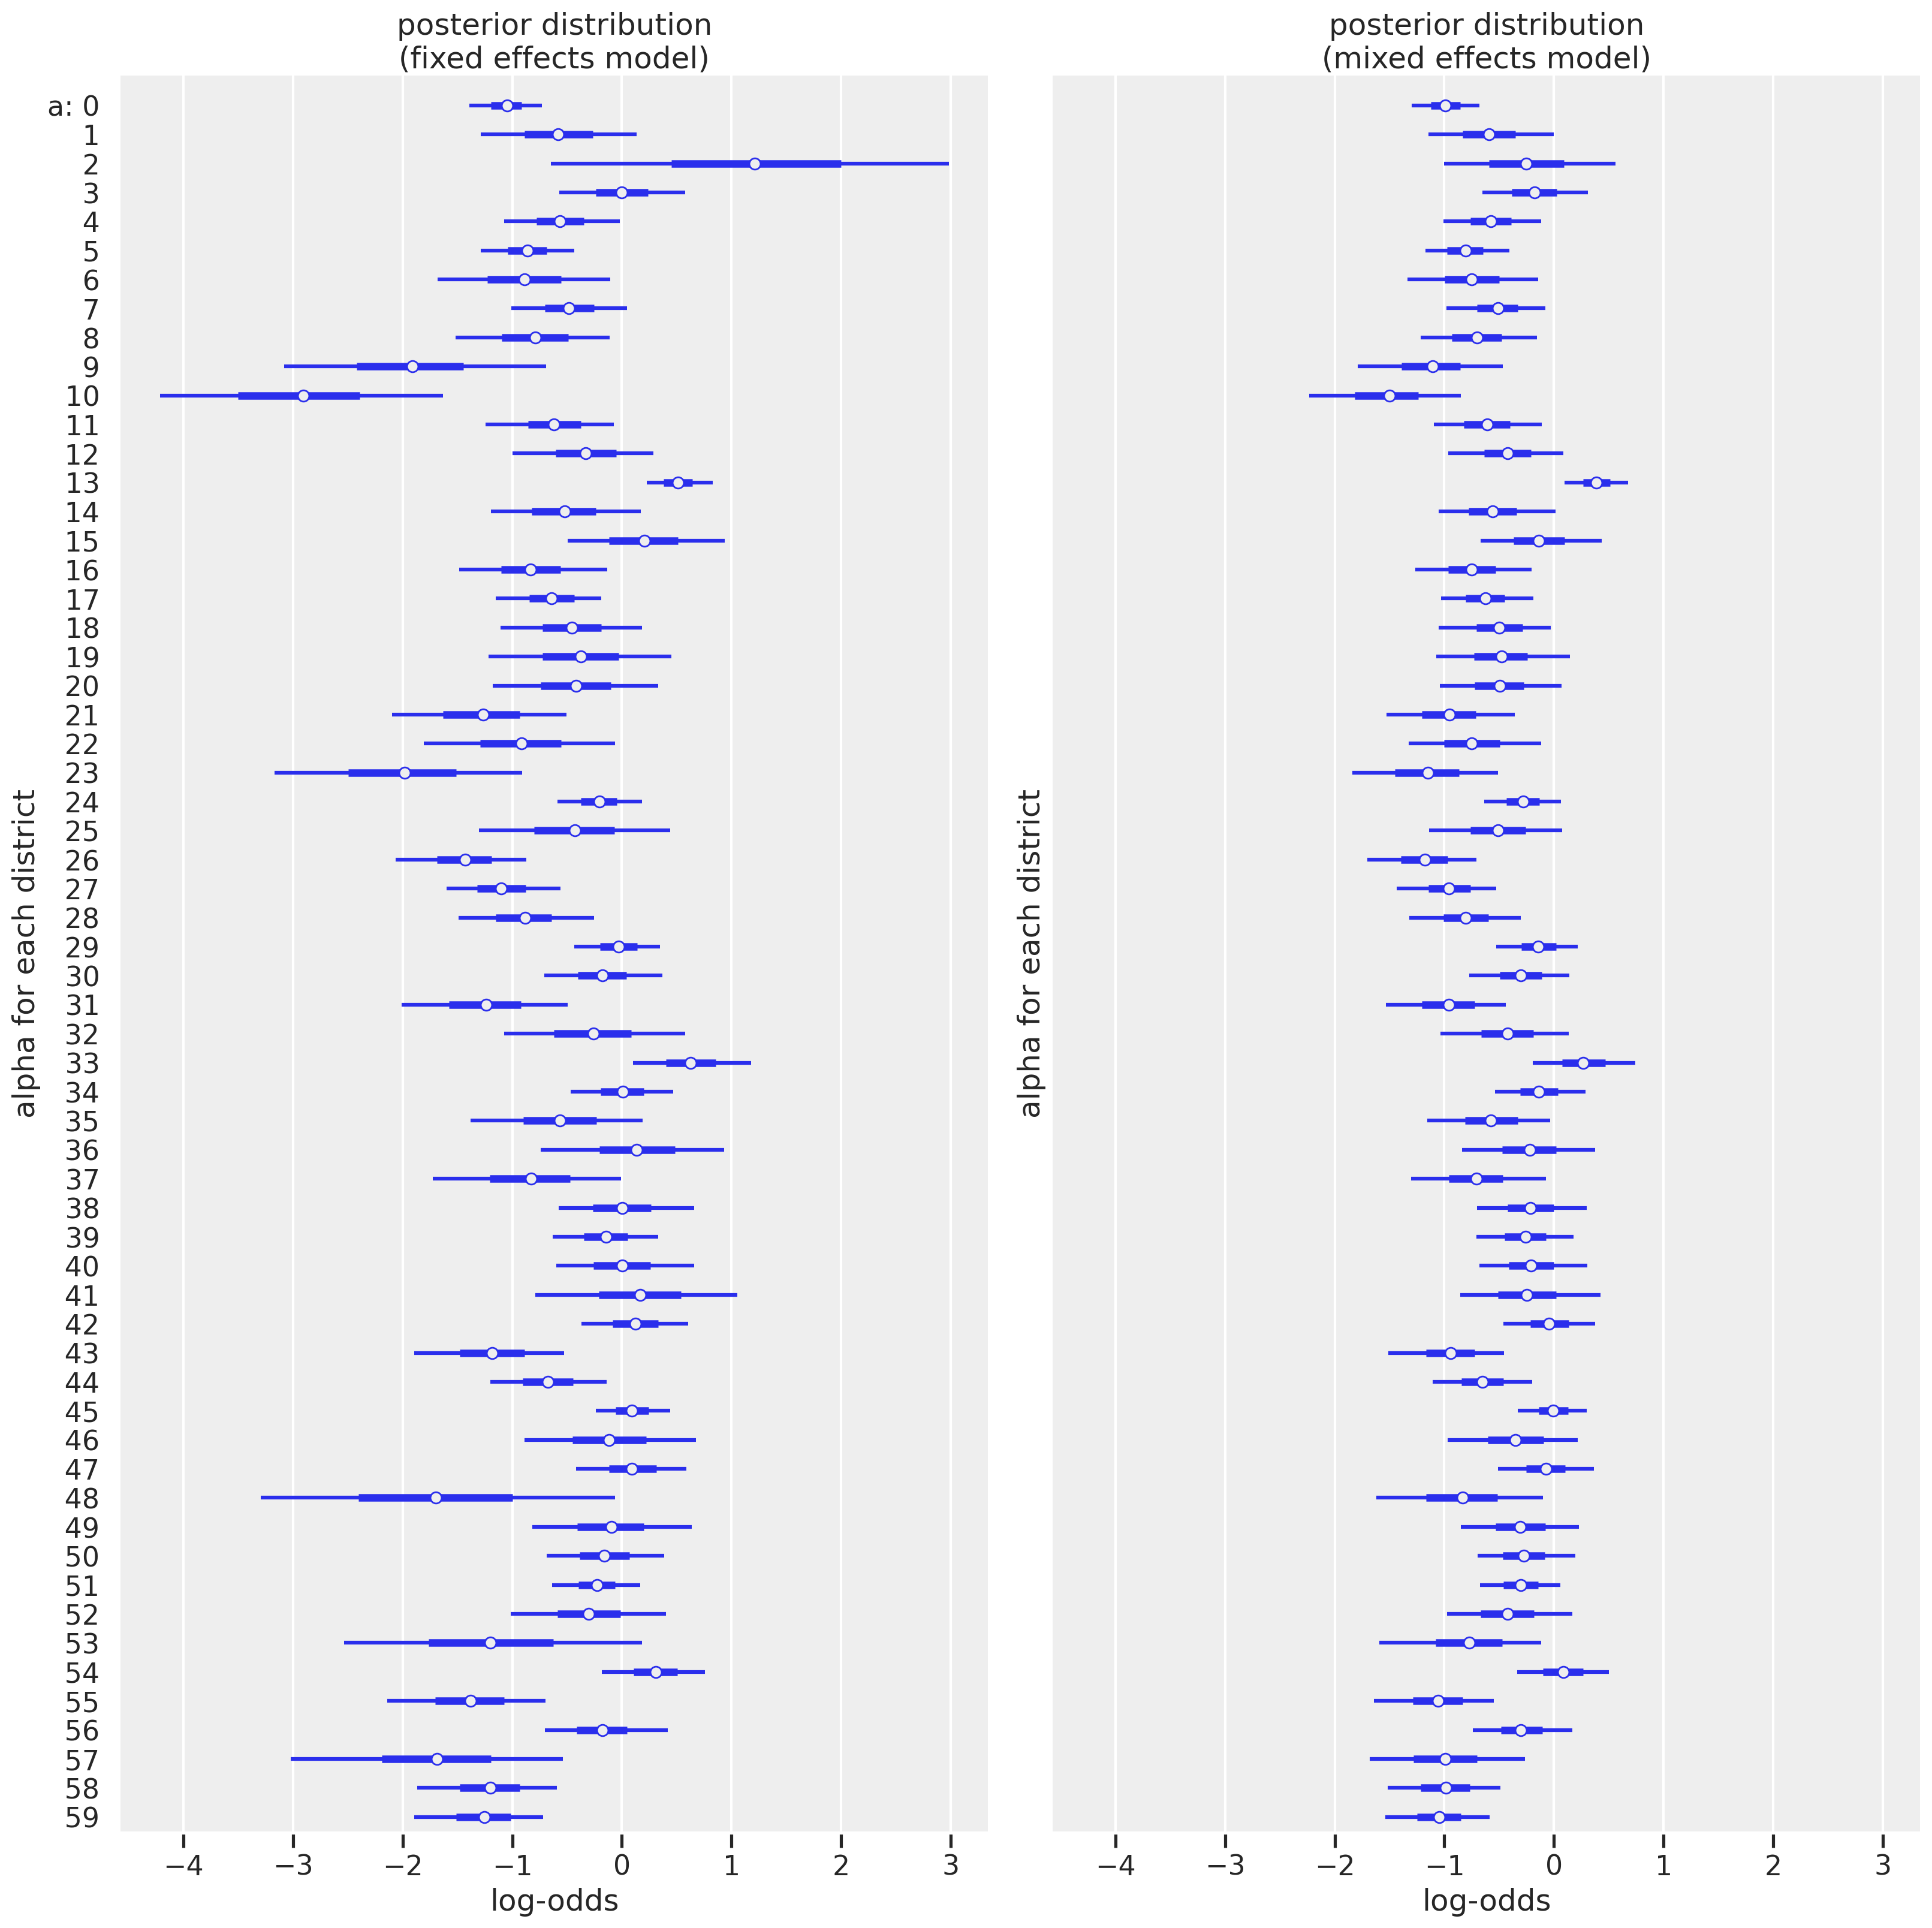

<IPython.core.display.Javascript object>

In [72]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16), sharex=True, sharey=True)
az.plot_forest(trace_mfe, combined=True, ax=ax1)
ax1.set(xlabel="log-odds", ylabel="alpha for each district", title='posterior distribution\n(fixed effects model)')

az.plot_forest(trace_mme, var_names='a', combined=True, ax=ax2)
ax2.set(xlabel="log-odds", ylabel="alpha for each district", title='posterior distribution\n(mixed effects model)');

The first thing that jumps out is that the uncertainty for several districts now is much smaller, particularly those with small sample sizes like district index 2. This is where the multilevel model really shines. Another change is that we see the mean estimates get pulled towards the center, especially those with more extreme values in the fixed effects models. It may be harder to appreciate in this visualization but we'll plot on the outcome scale. Let's explore these differences in different ways.

Let's look more closely at how sample size impacts the uncertainty for each district in the fixed-effects versus mixed-effects model for each district.

In [73]:
# Create a new dataframe
col2inspect = ["mean", "sd", "hdi_5.5%", "hdi_94.5%"]
df_summary = (
    pd.merge(
    az.summary(trace_mfe)[col2inspect],
    az.summary(trace_mme)[col2inspect],
    how="inner",
    left_index=True,
    right_index=True)
    .reset_index(drop=True)
)

# Add number of women for each district
df_summary["n_women"] = df_bangladesh.groupby("district_code").count().iloc[:, 0]
# Inspect
df_summary.head()

,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,n_women
0,-1.052,0.205,-1.389,-0.730,-0.992,0.198,-1.299,-0.679,117
1,-0.584,0.452,-1.287,0.134,-0.599,0.360,-1.144,-0.001,20
2,1.240,1.156,-0.647,2.980,-0.240,0.501,-1.003,0.559,2
3,-0.003,0.362,-0.572,0.579,-0.179,0.298,-0.652,0.309,30
4,-0.569,0.330,-1.077,-0.020,-0.577,0.279,-1.007,-0.118,39


<IPython.core.display.Javascript object>

[(0.0, 1.2),
 (0.0, 1.2),
 Text(0.5, 0, 'fixed effects SD'),
 Text(0, 0.5, 'mixed effects SD'),
 Text(0.5, 1.0, 'Impact of sample size on SD')]

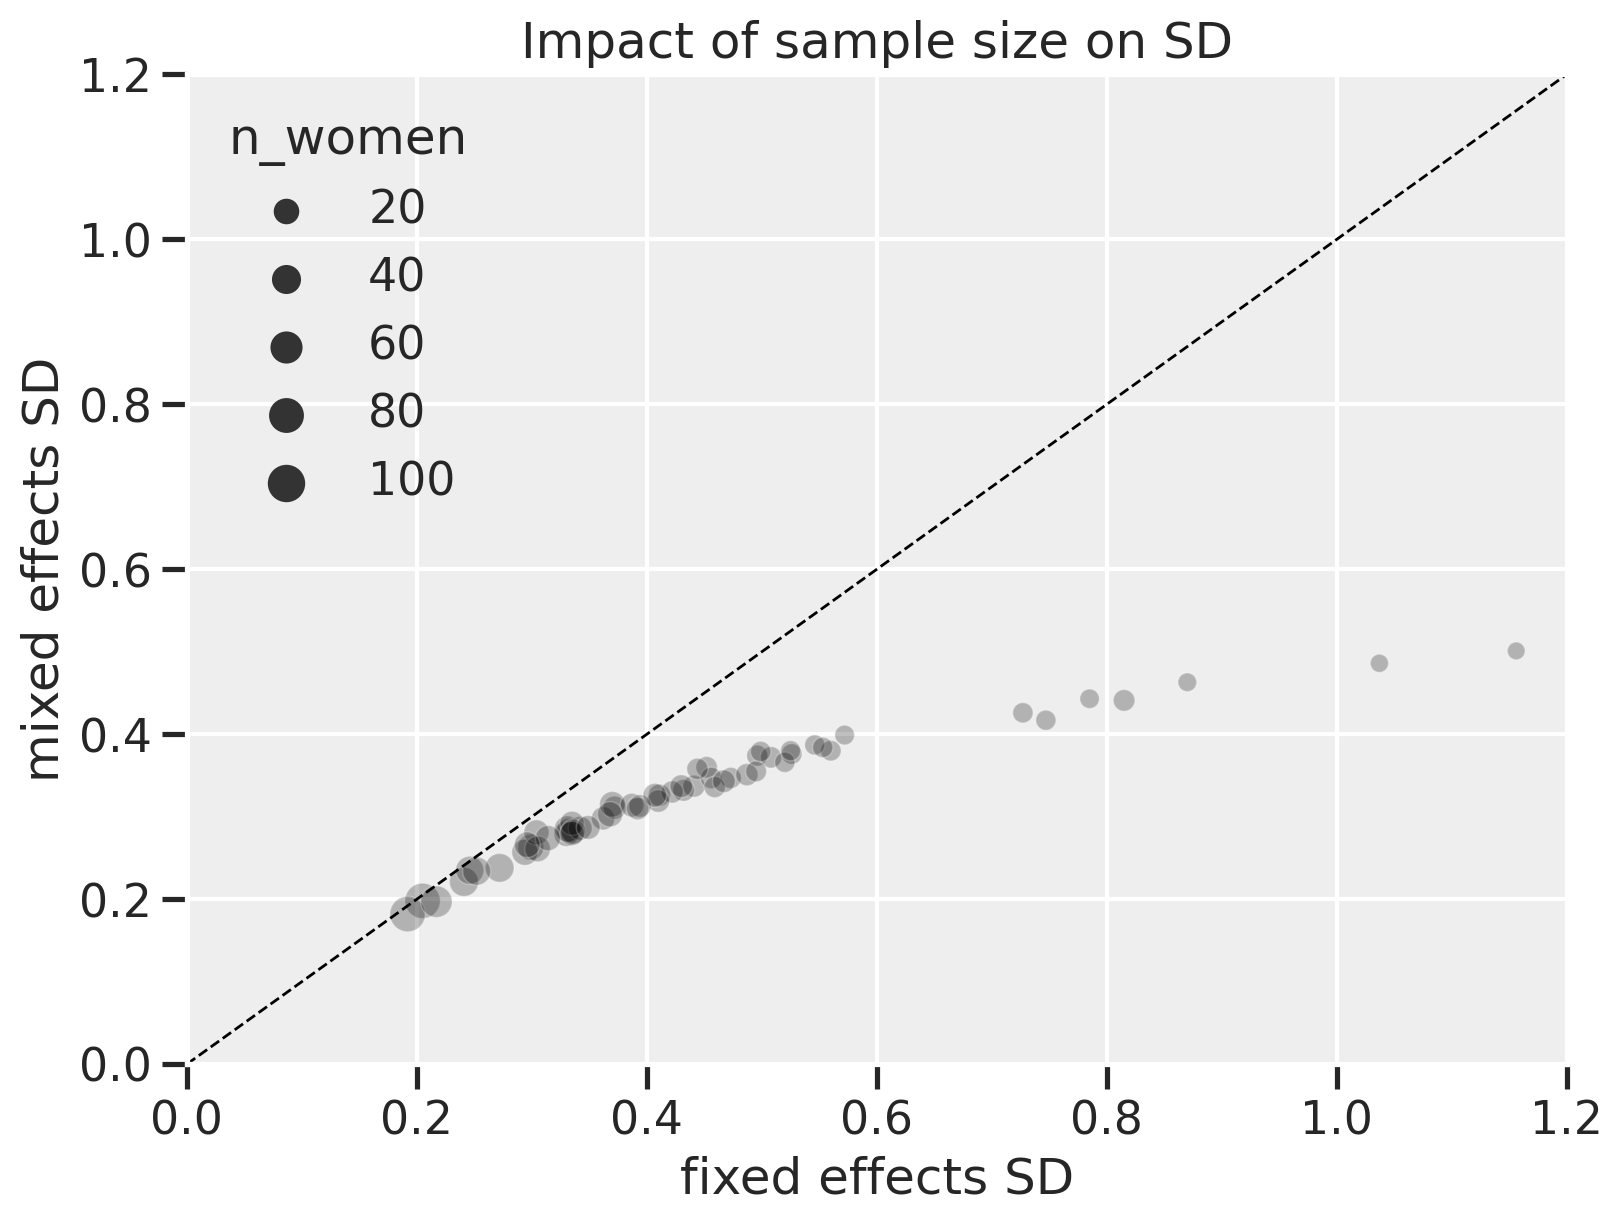

<IPython.core.display.Javascript object>

In [74]:
f, ax1 = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=df_summary, x="sd_x", y="sd_y", size="n_women", color="black", alpha=0.25, ax=ax1
)
ax1.plot([0, 1.2], [0, 1.2], color="black", lw=1, linestyle="--")
ax1.set(
    xlim=[0, 1.2], ylim=[0, 1.2], xlabel="fixed effects SD", ylabel="mixed effects SD", title="Impact of sample size on SD"
)

On the x-axis are the standard deviations of the $\alpha$ values for each district in the fixed effects model. On the y-axis are the corresponding SD values for the mixed effects model. The size of the points are the number of women in each district. The dashed diagonal line represents where values between the x and y-axes are equal.

Here, we can see that the fixed effects model shows greater uncertainty, especially when the number of women in each district gets lower (points at the right of the plot). The lower uncertainty with mixed effects is due to partial pooling. When the number of women is high, the mixed effects model shows uncertainty on par with the fixed effects model, meaning there's "less benefit" to using a mixed effects model but it also doesn't hurt.

Now, let's plot on the outcome scale. Here, we'll show the predicted proportion of women in each district using contraception with fixed-effects and mixed-effects estimates shown side-by-side. We'll use the `logistic` function to transform the log-odds back on the probability scale.

[(-2.0, 60.0),
 (0.0, 1.0),
 Text(0.5, 0, 'district index'),
 Text(0, 0.5, 'proportion predicted\nfor contraception use')]

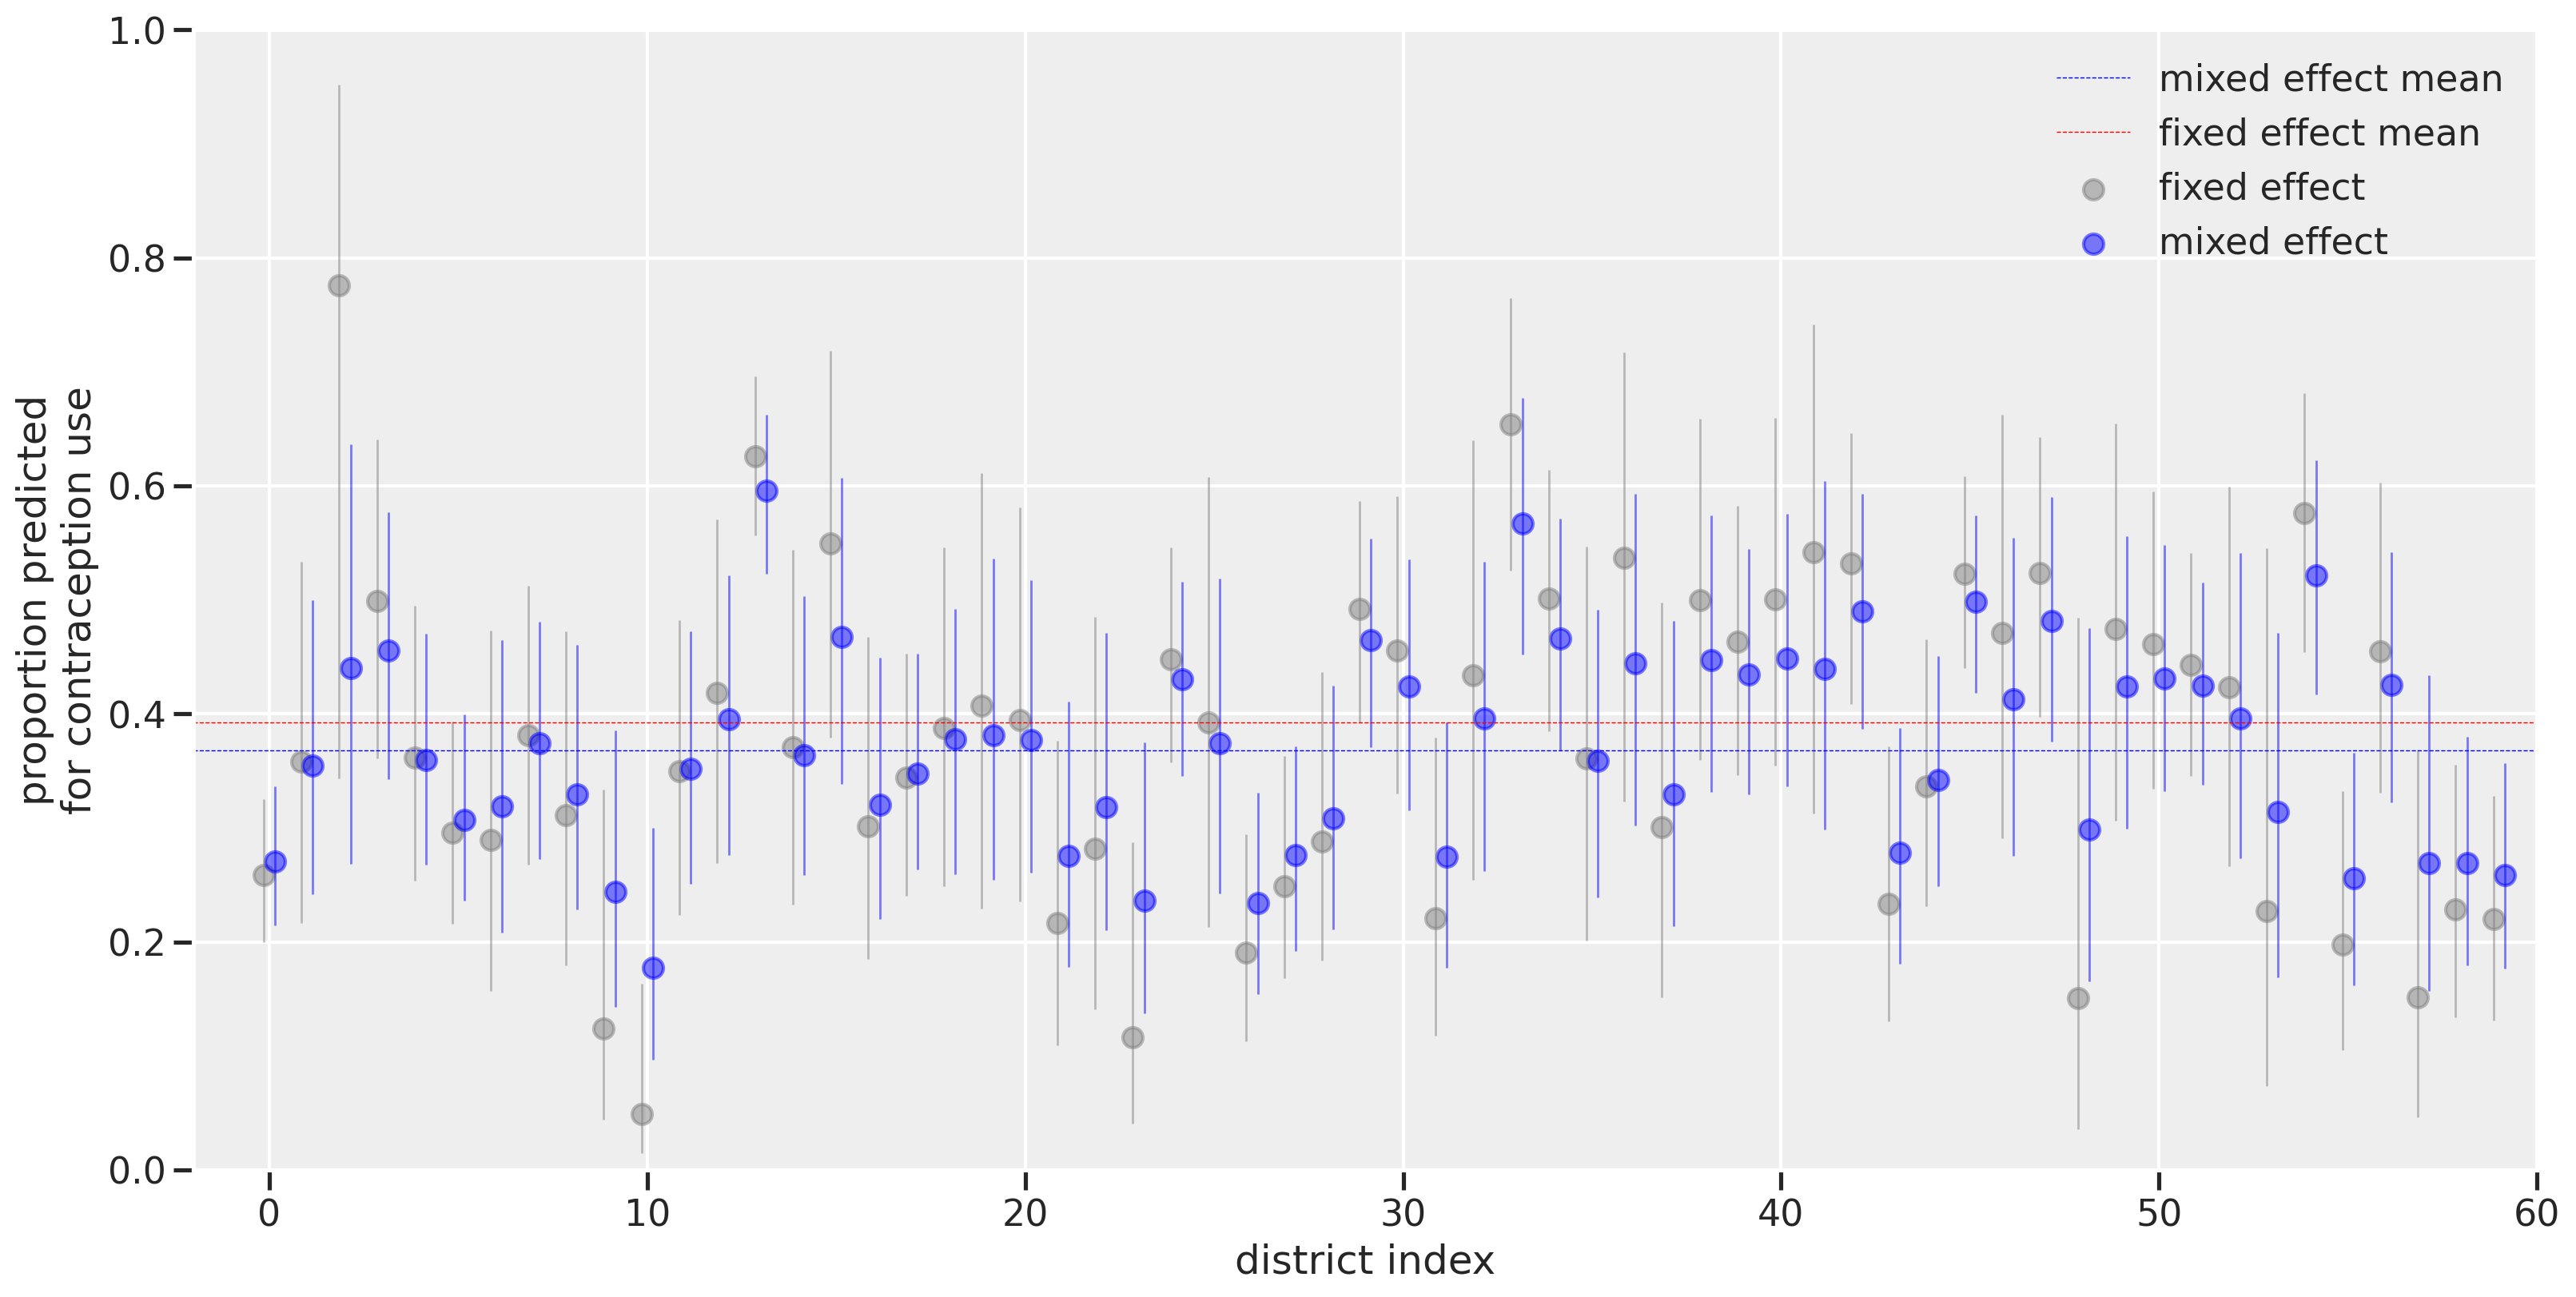

<IPython.core.display.Javascript object>

In [75]:
f, ax1 = plt.subplots(figsize=(16, 8))

# Plot means
ax1.scatter(
    df_summary.index - 0.15,
    logistic(df_summary["mean_x"]),
    color="gray",
    alpha=0.5,
    label="fixed effect",
)
ax1.scatter(
    df_summary.index + 0.15,
    logistic(df_summary["mean_y"]),
    color="blue",
    alpha=0.5,
    label="mixed effect",
)

# Plot uncertainties
ax1.vlines(
    x=df_summary.index - 0.15,
    ymin=logistic(df_summary["hdi_5.5%_x"]),
    ymax=logistic(df_summary["hdi_94.5%_x"]),
    color="gray",
    linewidth=1,
    alpha=0.5,
)

ax1.vlines(
    x=df_summary.index + 0.15,
    ymin=logistic(df_summary["hdi_5.5%_y"]),
    ymax=logistic(df_summary["hdi_94.5%_y"]),
    color="blue",
    linewidth=1,
    alpha=0.5,
)

# Plot average mixed effect line
me_mean = logistic(az.summary(trace_mme).loc["a_bar", "mean"])
ax1.plot(
    [-10, 62],
    [me_mean, me_mean],
    color="blue",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="mixed effect mean",
)

# Plot raw fixed effect line
fe_mean = df_bangladesh["use.contraception"].mean()
ax1.plot(
    [-10, 62],
    [fe_mean, fe_mean],
    color="red",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="fixed effect mean",
)

ax1.legend()
ax1.set(
    xlim=[-2, 60],
    ylim=[0, 1],
    xlabel="district index",
    ylabel="proportion predicted\nfor contraception use",
)

The district index is shown on the x-axis while the proportion predicted for contraception use is on the y-axis. Visualizing on this scale makes it more directly interpretable than log-odds when thinking about the proportion of women using contraception. The horizontal dashed lines represent the overall means for fixed effect (red) versus the mixed effect (blue). The difference in the lines is due to leveraging the sample size differences. As we had seen with the log-odds scale, the districts with the smallest number of women (like district index 2) had their estimates greatly affected by using a multilevel model. The estimates get pulled towards the horizontal blue dashed line, illustrating the concept of **shrinkage** that results from the **partial pooling** of information across estimates.

In this post, we covered a simple example of multilevel modeling using a binomial GLM. We used a dataset where clusters (districts) contained variable sample sizes. By contrasting a fixed effects model with a mixed effects model, we can see how multilevel modeling improves our estimates and reduces uncertainty. Here, we covered an example of varying intercepts. In a later post, we'll add varying slopes which will help us incorporate predictor variables.

Appendix: Environment and system parameters

In [76]:
%watermark -n -u -v -iv -w

Last updated: Sat Oct 23 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
numpy     : 1.20.1
scipy     : 1.6.0
seaborn   : 0.11.1
matplotlib: 3.3.4
sys       : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
pymc3     : 3.11.0
arviz     : 0.11.1
theano    : 1.1.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>